Stroke Prediction - Stroke is a severe medical condition caused by a disruption in blood supply to the brain, resulting from either a blockage or the rupture of a blood vessel. Prompt medical attention is crucial in such cases. Numerous factors contribute to an increased risk of stroke, making it essential to explore the relationships between these factors and the occurrence of stroke. Analyzing a dataset containing information such as age, gender, hypertension, heart disease, average glucose level, smoking status, and BMI enables the training of machine learning models. These models can identify patterns and make predictions about an individual's likelihood of experiencing a stroke. Integrating such predictive models into healthcare systems allows medical professionals to proactively identify individuals at higher risk of stroke, enabling preventive measures and better management of the condition. This approach has the potential to save lives and enhance patient outcomes.

Goal here is to classify whether a person has a stroke or not. That is, it is a classification problem.

The information about dataset:

id: unique identifier

gender: "Male", "Female" or "Other"

age: age of the patient

hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

ever_married: "No" or "Yes"

work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

Residence_type: "Rural" or "Urban"

avg_glucose_level: average glucose level in blood

bmi: body mass index

smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"

stroke: 1 if the patient had a stroke or 0 if not

## Installing Required Libraries

In [48]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

## Importing necessary libraries

In [49]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import logging
import csv
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler

In [50]:
# configure the memory allocation and the maximum runtime for the AutoML process

min_mem_size = 6
run_time = 222

In [51]:
# related to memory size for execution

pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

4


In [52]:
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)

try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:38188..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbw2_f56z
  JVM stdout: /tmp/tmpbw2_f56z/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbw2_f56z/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:38188
Connecting to H2O server at http://127.0.0.1:38188 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_unknownUser_llyhzi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Getting the Original Data

In [53]:
# Original df
df = pd.read_csv('https://raw.githubusercontent.com/pranitee23/Data-Science-Methods-and-Tools/main/healthcare-dataset-stroke-data.csv')

# Dataframe used for label encoding purpose
df_le = pd.read_csv('https://raw.githubusercontent.com/pranitee23/Data-Science-Methods-and-Tools/main/healthcare-dataset-stroke-data.csv')

In [54]:
# checking null values
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [55]:
# Imputing mean into null values of bmi
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

In [56]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [57]:
# dropping the id column
df.drop('id' , axis = 1 , inplace = True)

## Original Dataset EDA

### Q-Q Plots

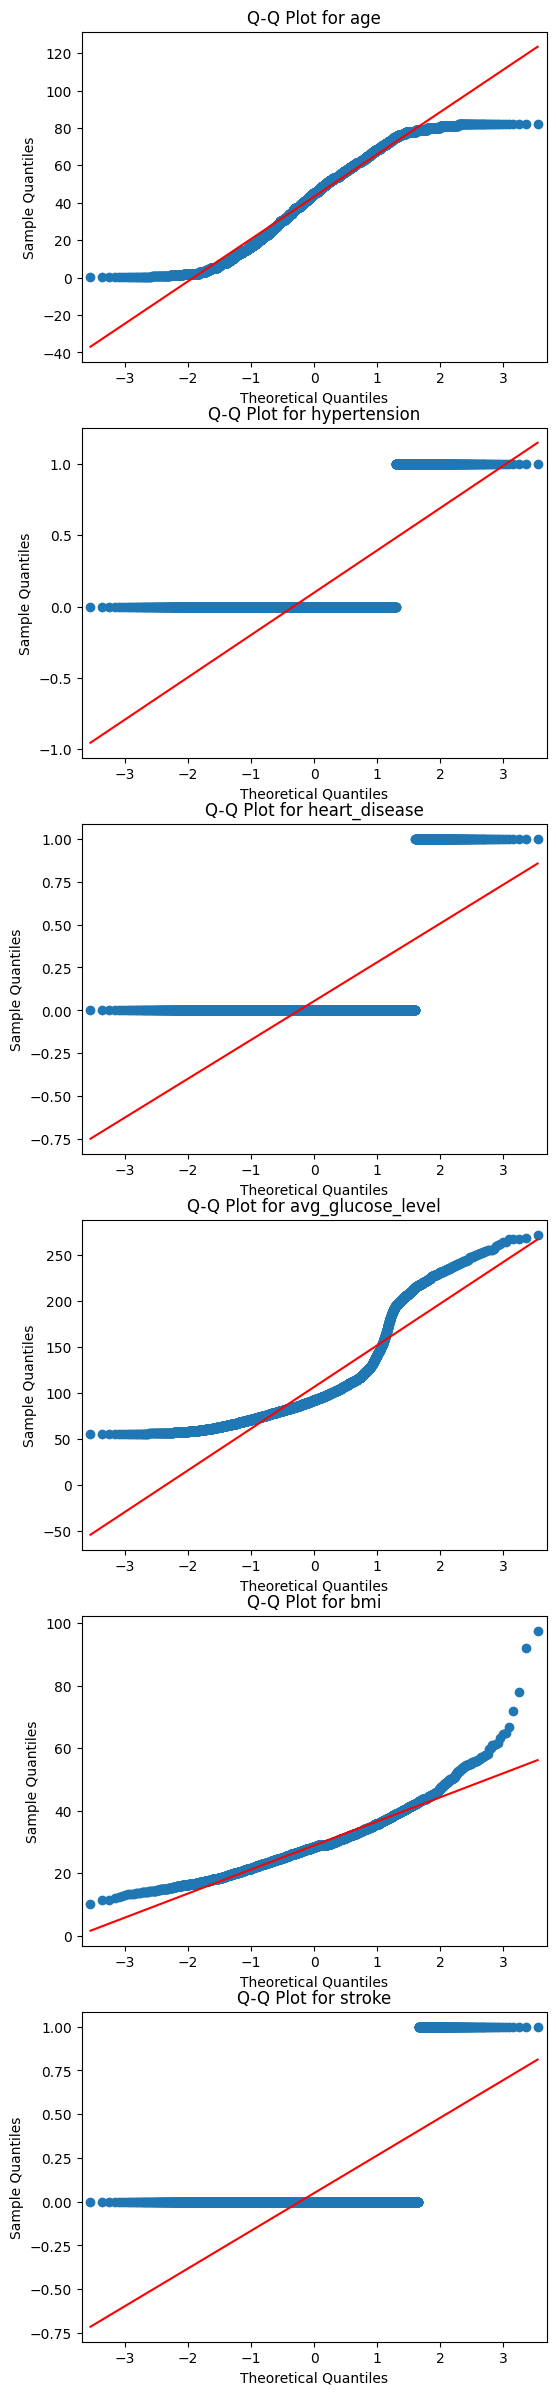

In [58]:
numeric_columns_list = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke'] # creating a list

fig, axes = plt.subplots(nrows=len(numeric_columns_list), figsize=(6, 5 * len(numeric_columns_list)))

# Plot Q-Q plots for each numeric variable
for i, variable in enumerate(numeric_columns_list):
    sm.qqplot(df[variable], line='s', ax=axes[i])
    axes[i].set_title(f'Q-Q Plot for {variable}')

plt.show()

qq plot is drawn for all the numeric columns:
- For age column, some of the datapoints align with the therotical values. All the values in age are continuous in nature
- For hypertension, heart disease, and stroke, values are binomial. It is either yes/no or 1/0.
- For bmi column there are values in the middle quartile which obey the theoritical values, and other values deviate from the standard line. This shows that there are more extreme values (both low and high) than what would be expected in a normal distribution
- For avg_glucose_level there are values which deviate from the straight line, showing that there are extreme values than what would be expected in a normal distribution.

## Label Encoding

In [59]:
df_le['bmi'].fillna(df_le['bmi'].mean(), inplace=True)
df_le.drop('id' , axis = 1 , inplace = True)

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df_le.columns:
    if df_le[col].dtype=='object':
        df_le[col]=le.fit_transform(df_le[col])

### Corelation Matrix

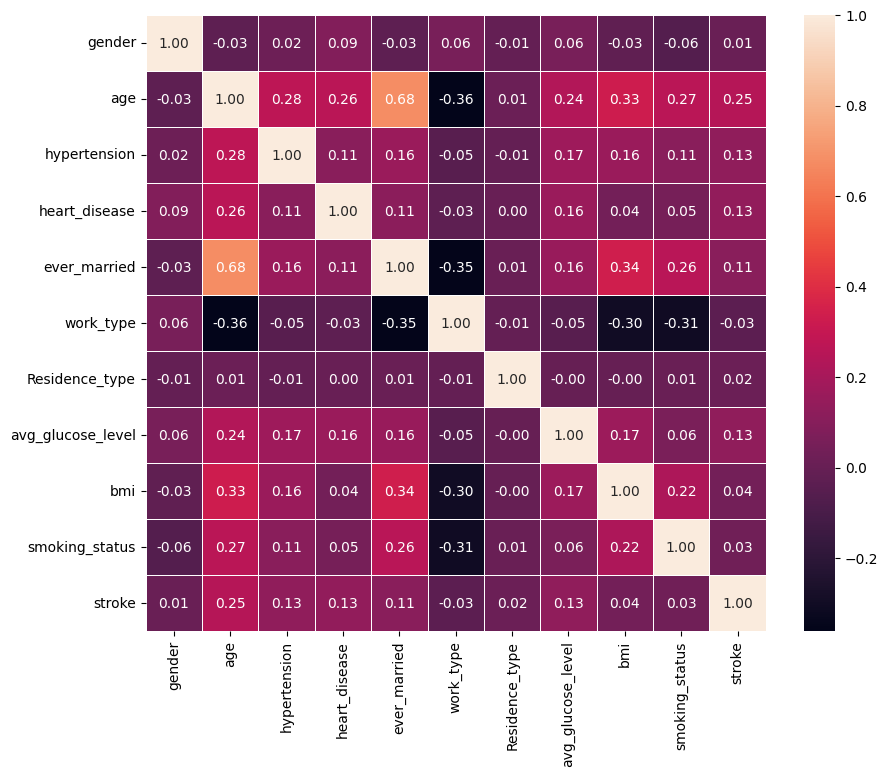

In [60]:
plt.figure(figsize=(10,8))
sns.heatmap(df_le.corr(),annot=True,linewidths=.5,fmt='.2f')
plt.show()

From the predictor variables, according to the heatmap, age and ever_married have a positive correlation of 0.68 value.

### OLS regression

In [61]:
model = sm.OLS(df_le['stroke'], df_le[['gender', 'ever_married', 'work_type', 'Residence_type','smoking_status',
                                   'age', 'hypertension', 'heart_disease', 'avg_glucose_level','bmi']]).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 stroke   R-squared (uncentered):                   0.123
Model:                            OLS   Adj. R-squared (uncentered):              0.122
Method:                 Least Squares   F-statistic:                              71.73
Date:                Tue, 20 Feb 2024   Prob (F-statistic):                   7.73e-138
Time:                        03:33:01   Log-Likelihood:                          805.37
No. Observations:                5110   AIC:                                     -1591.
Df Residuals:                    5100   BIC:                                     -1525.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
gender               -0.0029      0.006     -0.501      0.617      -0.014       0.009
ever_married         -0.0363      0.009     -4.251      0.000      -0.053      -0.020
work_type            -0.0011      0.002     -0.486      0.627      -0.006       0.003
Residence_type        0.0016      0.006      0.285      0.776      -0.010       0.013
smoking_status       -0.0067      0.003     -2.343      0.019      -0.012      -0.001
age                   0.0025      0.000     13.581      0.000       0.002       0.003
hypertension          0.0462      0.010      4.550      0.000       0.026       0.066
heart_disease         0.0583      0.013      4.337      0.000       0.032       0.085
avg_glucose_level     0.0003   6.49e-05      3.889      0.000       0.000       0.000
bmi                  -0.0020      0.000     -6.102      0.000      -0.003      -0.001
==============================================================================
Omnibus:                     3863.794   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49829.277
Skew:                           3.718   Prob(JB):                         0.00
Kurtosis:                      16.370   Cond. No.                         587.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

OLS Regression is a method which shows relation between the variables. A pvalue greater than 0.05 for a feature, is said to be not statistically significant.
Here fetures with a pvalue<0.05 are
- ever_married
- smoking_status
- age
- hypertension
- heart_disease
- avg_glucose_level
- bmi

### VIF

In [62]:
# Select features for VIF calculation (excluding target variable 'stroke')
from statsmodels.stats.outliers_influence import variance_inflation_factor
features_for_vif = df_le.drop(['stroke'], axis=1)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = features_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(features_for_vif.values, i) for i in range(features_for_vif.shape[1])]

print(vif_data)

            Variable        VIF
0             gender   1.702699
1                age   9.846254
2       hypertension   1.202235
3      heart_disease   1.163460
4       ever_married   5.704853
5          work_type   3.836147
6     Residence_type   1.973203
7  avg_glucose_level   6.696090
8                bmi  11.240513
9     smoking_status   2.950121


For VIF, we consider our threshold as 5 or 10.


The Variance Inflation Factor (VIF) values provide insights into the degree of multicollinearity among the independent variables in the dataset. Generally, a higher VIF indicates a stronger correlation between a variable and the other independent variables. Here are some interpretations based on the VIF values you provided:

- age (VIF: 9.846254):
The VIF for 'age' is relatively high (close to 10), suggesting a potentially strong correlation with other independent variables. You may want to investigate which variables are highly correlated with 'age' and consider whether it is acceptable or if further action is needed.
bmi (VIF: 11.240513):

- The VIF for 'bmi' is quite high (above 10), indicating a strong correlation with other independent variables. High VIF values, especially above 10, may indicate potential multicollinearity issues. Consider exploring which variables are correlated with 'bmi' and evaluate the impact on your analysis.
avg_glucose_level (VIF: 6.696090):

- The VIF for 'avg_glucose_level' is relatively high (around 6.7). Investigate the variables that are correlated with 'avg_glucose_level' to understand the multicollinearity implications.
ever_married (VIF: 5.704853):

- The VIF for 'ever_married' is moderate. While it is not extremely high, it's worth exploring the correlation patterns involving 'ever_married' with other variables.
work_type (VIF: 3.836147):

- The VIF for 'work_type' is moderate. Similar to 'ever_married', explore the correlations involving 'work_type' to assess the impact on multicollinearity.
smoking_status (VIF: 2.950121):

 The VIF for 'smoking_status' is moderate that is (2.950121).

Variables with VIF values below 5 are generally considered to have low multicollinearity. However, when VIF values exceed 5 or 10, it is often a sign that multicollinearity may be impacting the stability and interpretability of the model.

### Box Plot for outliers

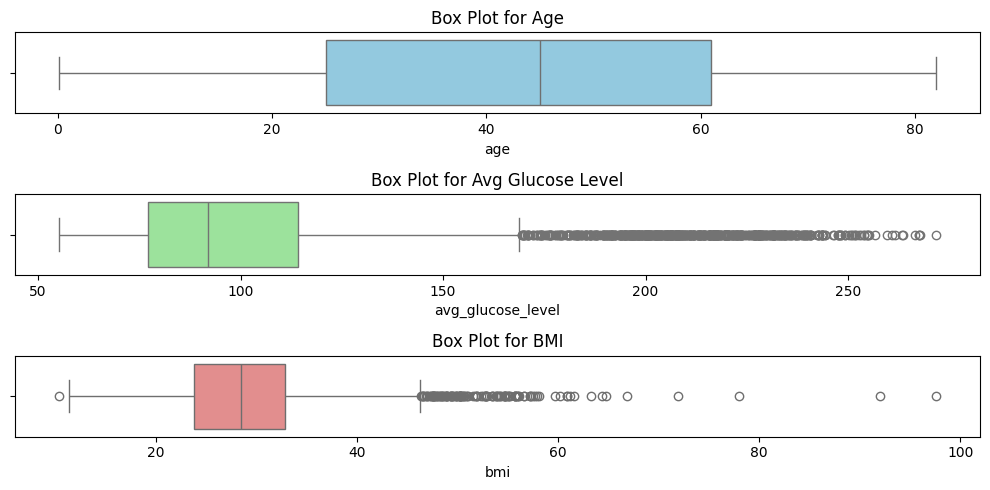

In [63]:
# Box plot
plt.figure(figsize=(10, 5))

# Box plot for 'age'
plt.subplot(3, 1, 1)
sns.boxplot(x=df_le['age'], color='skyblue')
plt.title('Box Plot for Age')

# Box plot for 'avg_glucose_level'
plt.subplot(3, 1, 2)
sns.boxplot(x=df_le['avg_glucose_level'], color='lightgreen')
plt.title('Box Plot for Avg Glucose Level')

# Box plot for 'bmi'
plt.subplot(3, 1, 3)
sns.boxplot(x=df_le['bmi'], color='lightcoral')
plt.title('Box Plot for BMI')

# Adjust layout
plt.tight_layout()
plt.show()

In [64]:
df_le.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,0.414286,43.226614,0.097456,0.054012,0.656164,2.167710,0.508023,106.147677,28.893237,1.376908,0.048728
std,0.493044,22.612647,0.296607,0.226063,0.475034,1.090293,0.499985,45.283560,7.698018,1.071534,0.215320
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,2.000000,0.000000,77.245000,23.800000,0.000000,0.000000
50%,0.000000,45.000000,0.000000,0.000000,1.000000,2.000000,1.000000,91.885000,28.400000,2.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,3.000000,1.000000,114.090000,32.800000,2.000000,0.000000
max,2.000000,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,97.600000,3.000000,1.000000


### Normalization using Robust Scaler

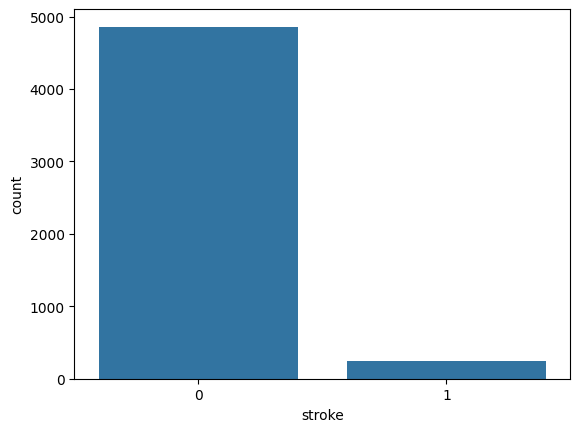

In [65]:
# To check whether dataset is balanced or not
# Assuming 'target' is your target variable
sns.countplot(x='stroke', data=df_le)
plt.show()

In [66]:
# Create a RobustScaler object
scaler = RobustScaler()

# Fit the scaler to the two columns with outliers and transform them
normalized_columns = scaler.fit_transform(df_le[['bmi', 'avg_glucose_level']])

# Update the original DataFrame with the normalized values
df_le[['bmi', 'avg_glucose_level']] = normalized_columns

Normalization is a data preprocessing technique used to scale numerical features of a dataset to a standard range. It ensures that all features contribute equally to the analysis and prevents features with larger magnitudes from dominating the model.


RobustScaler is a type of feature scaling method that scales the features based on their interquartile range (IQR). It is robust to outliers because it uses the median and the IQR rather than the mean and standard deviation.

In [67]:
print(df_le[['bmi', 'avg_glucose_level']].describe())

               bmi  avg_glucose_level
count  5110.000000       5.110000e+03
mean      0.054804       3.870994e-01
std       0.855335       1.229029e+00
min      -2.011111      -9.978287e-01
25%      -0.511111      -3.973402e-01
50%       0.000000       1.928254e-16
75%       0.488889       6.026598e-01
max       7.688889       4.881395e+00


## Parsing data through H2O

In [68]:
df_h2o = h2o.H2OFrame(df_le)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [69]:
df_h2o.head()

gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,67,0,1,1,2,1,3.71299,0.911111,1,1
0,61,0,0,1,3,0,2.9943,0.0548041,2,1
1,80,0,1,1,2,0,0.38092,0.455556,2,1
0,49,0,0,1,2,1,2.15348,0.666667,3,1
0,79,1,0,1,3,0,2.23192,-0.488889,2,1
1,81,0,0,1,2,1,2.56005,0.0666667,1,1
1,74,1,1,1,2,0,-0.591532,-0.111111,2,1
0,69,0,0,0,2,1,0.0679875,-0.622222,2,1
0,59,0,0,1,2,0,-0.427059,0.0548041,0,1
0,78,0,0,1,2,1,-0.904193,-0.466667,0,1


### Checking the missing values and datatype

In [70]:
missing_values_in_dataset = df_h2o.isna().sum()
print("Missing values in the entire dataset:")
print(missing_values_in_dataset)

Missing values in the entire dataset:
0.0


In [71]:
df_h2o.types

{'gender': 'int',
 'age': 'real',
 'hypertension': 'int',
 'heart_disease': 'int',
 'ever_married': 'int',
 'work_type': 'int',
 'Residence_type': 'int',
 'avg_glucose_level': 'real',
 'bmi': 'real',
 'smoking_status': 'int',
 'stroke': 'int'}

In [72]:
df_h2o.describe()

Rows:5110
Cols:11

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
type,int,real,int,int,int,int,int,real,real,int,int
mins,0.0,0.08,0.0,0.0,0.0,0.0,0.0,-0.997828742027412,-2.0111111111111115,0.0,0.0
mean,0.4142857142857141,43.226614481409,0.0974559686888454,0.05401174168297456,0.6561643835616439,2.1677103718199504,0.5080234833659492,0.3870993921486831,0.054804101310518265,1.3769080234833617,0.0487279843444227
maxs,2.0,82.0,1.0,1.0,1.0,4.0,1.0,4.881395033247388,7.688888888888891,3.0,1.0
sigma,0.4930436314174791,22.61264672311348,0.2966066742337912,0.22606298750336545,0.475033520037369,1.090293498184979,0.4999845441302678,1.2290286375514186,0.8553353140952311,1.0715337628679502,0.2153198569802376
zeros,2994,0,4612,4834,1757,657,2514,0,38,1544,4861
missing,0,0,0,0,0,0,0,0,0,0,0
0,1.0,67.0,0.0,1.0,1.0,2.0,1.0,3.7129868367485415,0.9111111111111118,1.0,1.0
1,0.0,61.0,0.0,0.0,1.0,3.0,0.0,2.9943004478219573,0.05480410131051866,2.0,1.0
2,1.0,80.0,0.0,1.0,1.0,2.0,0.0,0.3809200705658844,0.4555555555555559,2.0,1.0


### Train Test split - h2o

In [73]:
pct_rows = 0.80
df_train, df_test = df_h2o.split_frame([pct_rows])

In [74]:
print(df_train.shape)
print(df_test.shape)

(4092, 11)
(1018, 11)


In [75]:
X=df_h2o.columns
print(X)

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


In [76]:
#Seperate Dependent variable from Independent variable
y_target ='stroke'
X.remove(y_target)
print('Features except target variable: ',X)
print('Target Variable: ',y_target)

Features except target variable:  ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
Target Variable:  stroke


### Setting up the AutoML and training the dataset

In [77]:
#set the AutoML
aml = H2OAutoML(max_runtime_secs=run_time, sort_metric='MAE',max_models=10 ,seed=1, exclude_algos=['DeepLearning'])

#pass the data through H20AutoML
aml.train(x=X,y=y_target,training_frame=df_train)

AutoML progress: |
03:33:08.760: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█████
03:33:26.146: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
03:33:30.183: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
03:33:38.561: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

████
03:33:53.497: _response param, W

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_1_20240220_33308


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    22                 22                          17666                  7            7            7             32            76            59.2273

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.03032725205469948
RMSE: 0.17414721374371592
MAE: 0.07068643474895397
RMSLE: 0.1183057828320064
Mean Residual Deviance: 0.03032725205469948

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.04297178073514564
RMSE: 0.20729635967654048
MAE: 0.08365633440375957
RMSLE: 0.1455414910191514
Mean Residual Deviance: 0.04297178073514564

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0838895  0.00256166  0.0806809     0.0869505     0.0834241     0.0824383     0.0859537
mean_residual_deviance  0.0436095  0.00200037  0.0403758     0.0439579     0.0441973     0.0458635     0.0436532
mse                     0.0436095  0.00200037  0.0403758     0.0439579     0.0441973     0.0458635     0.0436532
r2                      0.0619127  0.0426541   0.130856      0.0537472     0.0496947     0.0138704     0.0613951
residual_deviance       0.0436095  0.00200037  0.0403758     0.0439579     0.0441973     0.0458635     0.0436532
rmse                    0.208784   0.00483045  0.200937      0.209661      0.210232      0.214158      0.208933
rmsle                   0.147352   0.00365841  0.141083      0.148602      0.148161      0.150713      0.148202

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-02-20 03:34:06  2.242 sec   0                  0.215608         0.092974        0.046487
    2024-02-20 03:34:06  2.317 sec   5                  0.19967          0.0851244       0.039868
    2024-02-20 03:34:06  2.383 sec   10                 0.188934         0.0796193       0.035696
    2024-02-20 03:34:06  2.449 sec   15                 0.181677         0.0748415       0.0330064
    2024-02-20 03:34:06  2.500 sec   20                 0.175864         0.071695        0.0309283
    2024-02-20 03:34:06  2.524 sec   22                 0.174147         0.0706864       0.0303273

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
age                135.14                 1                    0.380243
avg_glucose_level  86.6002                0.640817             0.243666
bmi                56.2659                0.416352             0.158315
smoking_status     23.1618                0.17139              0.0651701
heart_disease      10.9526                0.0810462            0.0308173
work_type          10.532                 0.0779335            0.0296337
hypertension       10.1788                0.0753204            0.0286401
Residence_type     8.64869                0.0639979            0.0243347
gender             8.26218                0.0611378            0.0232472
ever_married       5.66255                0.0419013            0.0159327

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

### Print the best model

In [78]:
# Get the AutoML leaderboard
leaderboard = aml.leaderboard

# Print the leaderboard
print(leaderboard)

model_id                                                      mae      rmse        mse     rmsle    mean_residual_deviance
GBM_2_AutoML_1_20240220_33308                           0.0836563  0.207296  0.0429718  0.145541                 0.0429718
GBM_3_AutoML_1_20240220_33308                           0.0843895  0.207968  0.0432508  0.146404                 0.0432508
GBM_1_AutoML_1_20240220_33308                           0.0846964  0.205471  0.0422183  0.143599                 0.0422183
StackedEnsemble_AllModels_1_AutoML_1_20240220_33308     0.0853141  0.206096  0.0424757  0.143962                 0.0424757
StackedEnsemble_BestOfFamily_1_AutoML_1_20240220_33308  0.0863331  0.205796  0.042352   0.1437                   0.042352
GBM_4_AutoML_1_20240220_33308                           0.0867647  0.208591  0.0435102  0.147079                 0.0435102
DRF_1_AutoML_1_20240220_33308                           0.088074   0.214566  0.0460385  0.153412                 0.0460385
XRT_1_AutoML_1_20

These are the metrics-
- MAE (Mean Absolute Error): This represents the average of the absolute differences between the predicted values and the actual values.
- RMSE (Root Mean Squared Error): This is the square root of the average of squared differences between prediction and actual observation.
- MSE (Mean Squared Error): This is the average of the squared differences between the predicted and actual values.
- RMSLE (Root Mean Squared Logarithmic Error): This is a variation of RMSE that is used when you do not want to penalize large differences when both the actual and predicted values are large numbers. It also penalizes underestimates more than overestimates.
- Mean Residual Deviance: Typically, this is similar to MSE, but in generalized linear models, it can be a measure of the distribution-specific loss.

model_id,mae,rmse,mse,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GBM_2_AutoML_1_20240220_33308,0.0836563,0.207296,0.0429718,0.145541,0.0429718,289,0.012927,GBM
GBM_4_AutoML_1_20240220_33308,0.0867647,0.208591,0.0435102,0.147079,0.0435102,482,0.012315,GBM
XGBoost_3_AutoML_1_20240220_33308,0.0901767,0.216188,0.0467375,0.15483,0.0467375,637,0.002754,XGBoost
GLM_1_AutoML_1_20240220_33308,0.0934931,0.206944,0.0428258,0.144939,0.0428258,140,0.000955,GLM


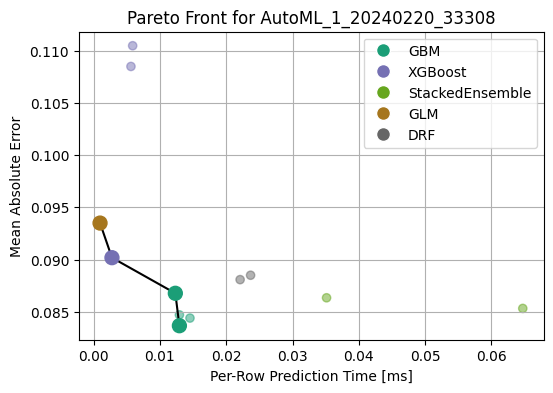

In [79]:
pf = aml.pareto_front()
fig = pf.figure()

# Adjust the size of the figure
fig.set_size_inches(6, 4)

# Display the plot
pf

This is a Pareto Front plot from the H2O AutoM, which helps to visualize the trade-off between model performance and computational efficiency. Models that are closer to the origin (bottom left corner) are more desirable as they have lower prediction times and lower errors.

- The GLM seems to be the fastest but not the most accurate.
- The GBMs appear to provide a good balance between prediction time and accuracy.
- XGBoost models are among the slower models, which is typical given their complexity, but they do not necessarily provide the best accuracy in this case.
The Stacked Ensemble is typically expected to be among the most accurate (as ensemble methods often are) but here it appears to be relatively slow in prediction time compared to other models.
- The DRF model seems to be the least accurate according to MAE.

In [80]:
best_model = aml.leader
print(best_model)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_2_AutoML_1_20240220_33308


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    22                 22                          17666                  7            7            7             32            76            59.2273

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.03032725205469948
RMSE: 0.17414721374371592
MAE: 0.07068643474895397
RMSLE: 0.1183057828320064
Mean Residual Deviance: 0.03032725205469948

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.04297178073514564
RMSE: 0.20729635967654048
MAE: 0.08365633440375957
RMSLE: 0.1455414910191514
Mean Residual Deviance: 0.04297

In [81]:
print("Best Model ID:", best_model.model_id)
print("Best Model MSE:", best_model.mse())

Best Model ID: GBM_2_AutoML_1_20240220_33308
Best Model MSE: 0.03032725205469948


In [82]:
best_model.algo

'gbm'

### Train the best model on our dataset

In [83]:
best_model.train(x=X,y=y_target,training_frame=df_train)

gbm Model Build progress: |

/usr/local/lib/python3.10/dist-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1708399965617_13


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          16375                  5            5            5             13            31            21.36

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.03065751027577856
RMSE: 0.1750928618641507
MAE: 0.07021557677130467
RMSLE: 0.12028876239441946
Mean Residual Deviance: 0.03065751027577856

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  --------------------
     2024-02-20 03:34:31  0.017 sec   0.0                0.21560845552407795  0.09297401218695821  0.046487006093478306
     2024-02-20 03:34:31  0.043 sec   1.0                0.21233127590619733  0.0914977639913559   0.045084570727953695
     2024-02-20 03:34:31  0.055 sec   2.0                0.20962865724943175  0.0901701004068683   0.043944173940199734
     2024-02-20 03:34:31  0.074 sec   3.0                0.20732852034247523  0.08895181117166026  0.04298511534740017
     2024-02-20 03:34:31  0.095 sec   4.0                0.20499998279780407  0.08768588231415839  0.042024992947099965
     2024-02-20 03:34:31  0.112 sec   5.0                0.20309600591006707  0.08660369966850996  0.041247987616622
     2024-02-20 03:34:31  0.124 sec   6.0                0.20129037308582357  0.08557266226395208  0.04051781429703004
     2024-02-20 03:34:31  0.135 sec   7.0                0.19924085165402755  0.08441656760876873  0.03969691696782221
     2024-02-20 03:34:31  0.148 sec   8.0                0.19807674428627775  0.08360639736757323  0.039234396627051464
     2024-02-20 03:34:32  0.160 sec   9.0                0.19709792201499798  0.08293169727075557  0.038847590862630225
---  ---                  ---         ---                ---                  ---                  ---
     2024-02-20 03:34:32  0.601 sec   41.0               0.17820080950830847  0.0714664037796747   0.031755528509416445
     2024-02-20 03:34:32  0.612 sec   42.0               0.17811770913929473  0.07144999418410865  0.0317259183090304
     2024-02-20 03:34:32  0.624 sec   43.0               0.17744685068067148  0.07110769463848797  0.03148738481648852
     2024-02-20 03:34:32  0.644 sec   44.0               0.17713366994362204  0.0709786189042389   0.03137633702769603
     2024-02-20 03:34:32  0.658 sec   45.0               0.176997728730477    0.07092030270593826  0.03132819597574752
     2024-02-20 03:34:32  0.691 sec   46.0               0.17626703318412698  0.07057870567114115  0.031070066987534124
     2024-02-20 03:34:32  0.712 sec   47.0               0.17588803581936738  0.07045197765191     0.03093660114439506
     2024-02-20 03:34:32  0.725 sec   48.0               0.17564490396659144  0.07037516005792302  0.03085113228943313
     2024-02-20 03:34:32  0.737 sec   49.0               0.17530959049760805  0.07029268217635873  0.03073345252043903
     2024-02-20 03:34:32  0.747 sec   50.0               0.1750928618641507   0.07021557677130467  0.03065751027577856
[51 rows x 7 columns]


Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
age                139.094                1                    0.40741
avg_glucose_level  79.1904                0.569331             0.231951
bmi                62.8365                0.451757             0.18405
smoking_status     15.8284       

### Prediction on the test data

In [84]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [85]:
print(predictions)

  predict
0.0166193
0.0343995
0.0635218
0.0249688
0.0405634
0.160872
0.15286
0.0268936
0.118665
0.0337578
[1018 rows x 1 column]



In [86]:
target_column = "stroke"

# Add the actual labels to the predictions DataFrame
predictions[target_column] = df_test[target_column]

# Evaluate model performance
perf = best_model.model_performance(df_test)

In [87]:
print(perf)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.044539540332245275
RMSE: 0.2110439298635364
MAE: 0.08113666760205131
RMSLE: 0.14901028852148238
Mean Residual Deviance: 0.044539540332245275


## Regularization

In [88]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

#without regularization
house_glm = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = 0, compute_p_values = True)

In [89]:
# With regularization

house_glm_regularization = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = .001, alpha = 0.5)

### With Regularization
- 0 = L1 regularization (Ridge)
- 1 = L2 regularization (Lasso)
- between 0 and 1 = combination of L1 and L2 regularization (Elastic Net)

In [90]:
house_glm_regularization.train(x = X, y = y_target, training_frame = df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708399965617_14


GLM Model: summary
    family    link    regularization                              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 0.001 )  10                            10                             5                       py_239_sid_b2f4

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.041762758493977835
RMSE: 0.20435938562732525
LogLoss: 0.15399378159508786
AUC: 0.8504772610483042
AUCPR: 0.21016327986413327
Gini: 0.7009545220966085
Null degrees of freedom: 4091
Residual degrees of freedom: 4081
Null deviance: 1597.4502666411154
Residual deviance: 1260.2851085741988
AIC: 1282.2851085741988

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12310830568251391
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      3433  459  0.1179   (459.0/3892.0)
1      82    118  0.41     (82.0/200.0)
Total  3515  577  0.1322   (541.0/4092.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.123108     0.303732  176
max f2                       0.0895158    0.44316   212
max f0point5                 0.182888     0.265523  109
max accuracy                 0.46574      0.951369  0
max precision                0.46574      1         0
max recall                   0.000880017  1         399
max specificity              0.46574      1         0
max absolute_mcc             0.0895158    0.294825  212
max min_per_class_accuracy   0.0618307    0.775694  251
max mean_per_class_accuracy  0.0426653    0.782379  283
max tns                      0.46574      3892      0
max fns                      0.46574      199       0
max fps                      0.000880017  3892      399
max tps                      0.000880017  200       399
max tnr                      0.46574      1         0
max fnr                      0.46574      0.995     0
max fpr                      0.000880017  1         399
max tpr                      0.000880017  1         399

Gains/Lift Table: Avg response rate:  4.89 %, avg score:  4.89 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100196                   0.294056           5.98829    5.98829            0.292683         0.343775    0.292683                    0.343775            0.06            0.06                       498.829   498.829            0.0525488
2        0.0200391                   0.258576           4.49122    5.23976            0.219512         0.274983    0.256098                    0.309379            0.045           0.105                      349.122   423.976            0.0893268
3        0.0300587                   0.235475           5.48927    5.32293            0.268293         0.247681    0.260163                    0.288813            0.055           0.16                       448.927   432.293            0.136619
4        0.0400782                   0.21522            4.49122    5.115              0.219512         0.225051    0.25                        0.272873            0.045           0.205                      349.12

#### Elastic Net:
- Accuracy = 1 - training_classification error = 1 - 0.1322 = 0.8678(approx)

### Regularization with Lasso

In [91]:
house_glm_regularization_lasso = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = .001, alpha = 1)
house_glm_regularization_lasso.train(x = X, y = y_target, training_frame = df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708399965617_16


GLM Model: summary
    family    link    regularization           number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  -----------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Lasso (lambda = 0.001 )  10                            9                              5                       py_239_sid_b2f4

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.04178341121422301
RMSE: 0.20440990977499846
LogLoss: 0.1540459449557816
AUC: 0.8503481500513874
AUCPR: 0.20929801208167656
Gini: 0.7006963001027748
Null degrees of freedom: 4091
Residual degrees of freedom: 4082
Null deviance: 1597.4502666411154
Residual deviance: 1260.7120135181171
AIC: 1280.7120135181171

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16257303406987084
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      3618  274  0.0704   (274.0/3892.0)
1      115   85   0.575    (115.0/200.0)
Total  3733  359  0.0951   (389.0/4092.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.162573     0.304114  127
max f2                       0.0863824    0.44099   210
max f0point5                 0.185981     0.261438  103
max accuracy                 0.367234     0.951613  7
max precision                0.44913      1         0
max recall                   0.000805632  1         399
max specificity              0.44913      1         0
max absolute_mcc             0.0863824    0.292232  210
max min_per_class_accuracy   0.0624614    0.775     244
max mean_per_class_accuracy  0.0447923    0.783931  275
max tns                      0.44913      3892      0
max fns                      0.44913      199       0
max fps                      0.000805632  3892      399
max tps                      0.000805632  200       399
max tnr                      0.44913      1         0
max fnr                      0.44913      0.995     0
max fpr                      0.000805632  1         399
max tpr                      0.000805632  1         399

Gains/Lift Table: Avg response rate:  4.89 %, avg score:  4.89 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------  --------------------
1        0.0100196                   0.29256            5.48927    5.48927            0.268293         0.338519    0.268293                    0.338519            0.055           0.055                      448.927    448.927            0.0472919
2        0.0200391                   0.257098           4.99024    5.23976            0.243902         0.272936    0.256098                    0.305727            0.05            0.105                      399.024    423.976            0.0893268
3        0.0300587                   0.233857           5.98829    5.48927            0.292683         0.245845    0.268293                    0.285767            0.06            0.165                      498.829    448.927            0.141876
4        0.0400782                   0.215558           2.99415    4.86549            0.146341         0.224509    0.237805                    0.270452            0.03            0.195                      199.415    386.549            0.162883
5        0.0500978  

#### Lasso Regularization:
- Accuracy = 1 - training_classification error = 1 - 0.09597 = 0.90403(approx)

### Ridge Regularization

In [92]:
house_glm_regularization_ridge = H2OGeneralizedLinearEstimator(family = 'binomial', lambda_ = .001, alpha = 0)
house_glm_regularization_ridge.train(x = X, y = y_target, training_frame = df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708399965617_18


GLM Model: summary
    family    link    regularization            number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Ridge ( lambda = 0.001 )  10                            10                             5                       py_239_sid_b2f4

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.04175142538689915
RMSE: 0.20433165537160206
LogLoss: 0.15398737158907796
AUC: 0.8505723278520041
AUCPR: 0.2106448996416087
Gini: 0.7011446557040082
Null degrees of freedom: 4091
Residual degrees of freedom: 4081
Null deviance: 1597.4502666411154
Residual deviance: 1260.2326490850144
AIC: 1282.2326490850144

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12279911051059285
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      3440  452  0.1161   (452.0/3892.0)
1      83    117  0.415    (83.0/200.0)
Total  3523  569  0.1307   (535.0/4092.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.122799     0.304291  176
max f2                       0.0855718    0.444162  216
max f0point5                 0.164696     0.263158  127
max accuracy                 0.482966     0.951369  0
max precision                0.482966     1         0
max recall                   0.000958736  1         399
max specificity              0.482966     1         0
max absolute_mcc             0.0855718    0.295124  216
max min_per_class_accuracy   0.0623975    0.779805  251
max mean_per_class_accuracy  0.065052     0.782027  247
max tns                      0.482966     3892      0
max fns                      0.482966     199       0
max fps                      0.000958736  3892      399
max tps                      0.000958736  200       399
max tnr                      0.482966     1         0
max fnr                      0.482966     0.995     0
max fpr                      0.000958736  1         399
max tpr                      0.000958736  1         399

Gains/Lift Table: Avg response rate:  4.89 %, avg score:  4.89 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100196                   0.301215           5.98829    5.98829            0.292683         0.349964    0.292683                    0.349964            0.06            0.06                       498.829   498.829            0.0525488
2        0.0200391                   0.258994           4.49122    5.23976            0.219512         0.278167    0.256098                    0.314066            0.045           0.105                      349.122   423.976            0.0893268
3        0.0300587                   0.236894           4.99024    5.15659            0.243902         0.249961    0.252033                    0.292697            0.05            0.155                      399.024   415.659            0.131362
4        0.0400782                   0.213737           4.99024    5.115              0.243902         0.226446    0.25                        0.276135            0.05            0.205                      399.024   411.5              0.173397
5        0.0500978      

#### Ridge regularization:
- Accuracy = 1 - training_classification error = 1 - 0.13074 = 0.86921(approx)

### Without Regularization

In [93]:
#Model details without regularization
house_glm.train(x = X, y = y_target, training_frame = df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708399965617_20


GLM Model: summary
    family    link    regularization    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ----------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   None              10                            10                             6                       py_239_sid_b2f4

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.041750486474595255
RMSE: 0.2043293578382589
LogLoss: 0.15389817430269648
AUC: 0.8505260791366906
AUCPR: 0.2112273561446667
Gini: 0.7010521582733813
Null degrees of freedom: 4091
Residual degrees of freedom: 4081
Null deviance: 1597.4502666411154
Residual deviance: 1259.5026584932673
AIC: 1281.5026584932673

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17240380005285244
       0     1    Error    Rate
-----  ----  ---  -------  --------------
0      3648  244  0.0627   (244.0/3892.0)
1      121   79   0.605    (121.0/200.0)
Total  3769  323  0.0892   (365.0/4092.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.172404     0.302103  124
max f2                       0.0890089    0.446371  215
max f0point5                 0.176288     0.265884  120
max accuracy                 0.492004     0.951369  0
max precision                0.492004     1         0
max recall                   0.000745025  1         399
max specificity              0.492004     1         0
max absolute_mcc             0.0890089    0.297744  215
max min_per_class_accuracy   0.0611348    0.778777  251
max mean_per_class_accuracy  0.057606     0.781364  257
max tns                      0.492004     3892      0
max fns                      0.492004     199       0
max fps                      0.000745025  3892      399
max tps                      0.000745025  200       399
max tnr                      0.492004     1         0
max fnr                      0.492004     0.995     0
max fpr                      0.000745025  1         399
max tpr                      0.000745025  1         399

Gains/Lift Table: Avg response rate:  4.89 %, avg score: 30.25 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100196                   0.539681           0          0                  0                0.568462  0                           0.568462            0               0                          -100      -100               -0.0105344
2        0.0200391                   0.530294           0          0                  0                0.534839  0                           0.551651            0               0                          -100      -100               -0.0210689
3        0.0300587                   0.524673           0          0                  0                0.527325  0                           0.543542            0               0                          -100      -100               -0.0316033
4        0.0400782                   0.519781           0          0                  0                0.522324  0                           0.538238            0               0                          -100      -100               -0.0421377
5        0.0500978                   0.514582        

#### Accuracy(Without Regularization):
-  1 - Training Classification Error Accuracy = 1 - 0.0894183 Accuracy ≈ 0.9108

## Explaining the AutoML model

In [94]:
import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
GLM_1_AutoML_1_20240220_33308,0.20747,0.0430437,0.0900069,0.145201,0.0430437,140,0.001292,GLM
StackedEnsemble_AllModels_1_AutoML_1_20240220_33308,0.207499,0.043056,0.0828299,0.145,0.043056,2021,0.085678,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240220_33308,0.20757,0.0430851,0.08405,0.145077,0.0430851,1807,0.040588,StackedEnsemble
GBM_1_AutoML_1_20240220_33308,0.207692,0.0431359,0.0817438,0.145274,0.0431359,726,0.014491,GBM
GBM_2_AutoML_1_20240220_33308,0.208723,0.0435654,0.0805858,0.146549,0.0435654,289,0.011563,GBM
GBM_3_AutoML_1_20240220_33308,0.210098,0.0441412,0.0809281,0.147685,0.0441412,305,0.010594,GBM
GBM_4_AutoML_1_20240220_33308,0.210272,0.0442141,0.0813724,0.147788,0.0442141,482,0.014205,GBM
XRT_1_AutoML_1_20240220_33308,0.211953,0.0449239,0.0889869,0.149336,0.0449239,781,0.026883,DRF
DRF_1_AutoML_1_20240220_33308,0.216866,0.0470307,0.0866121,0.154391,0.0470307,1076,0.024069,DRF
XGBoost_3_AutoML_1_20240220_33308,0.217621,0.0473587,0.0870766,0.155474,0.0473587,637,0.003107,XGBoost


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

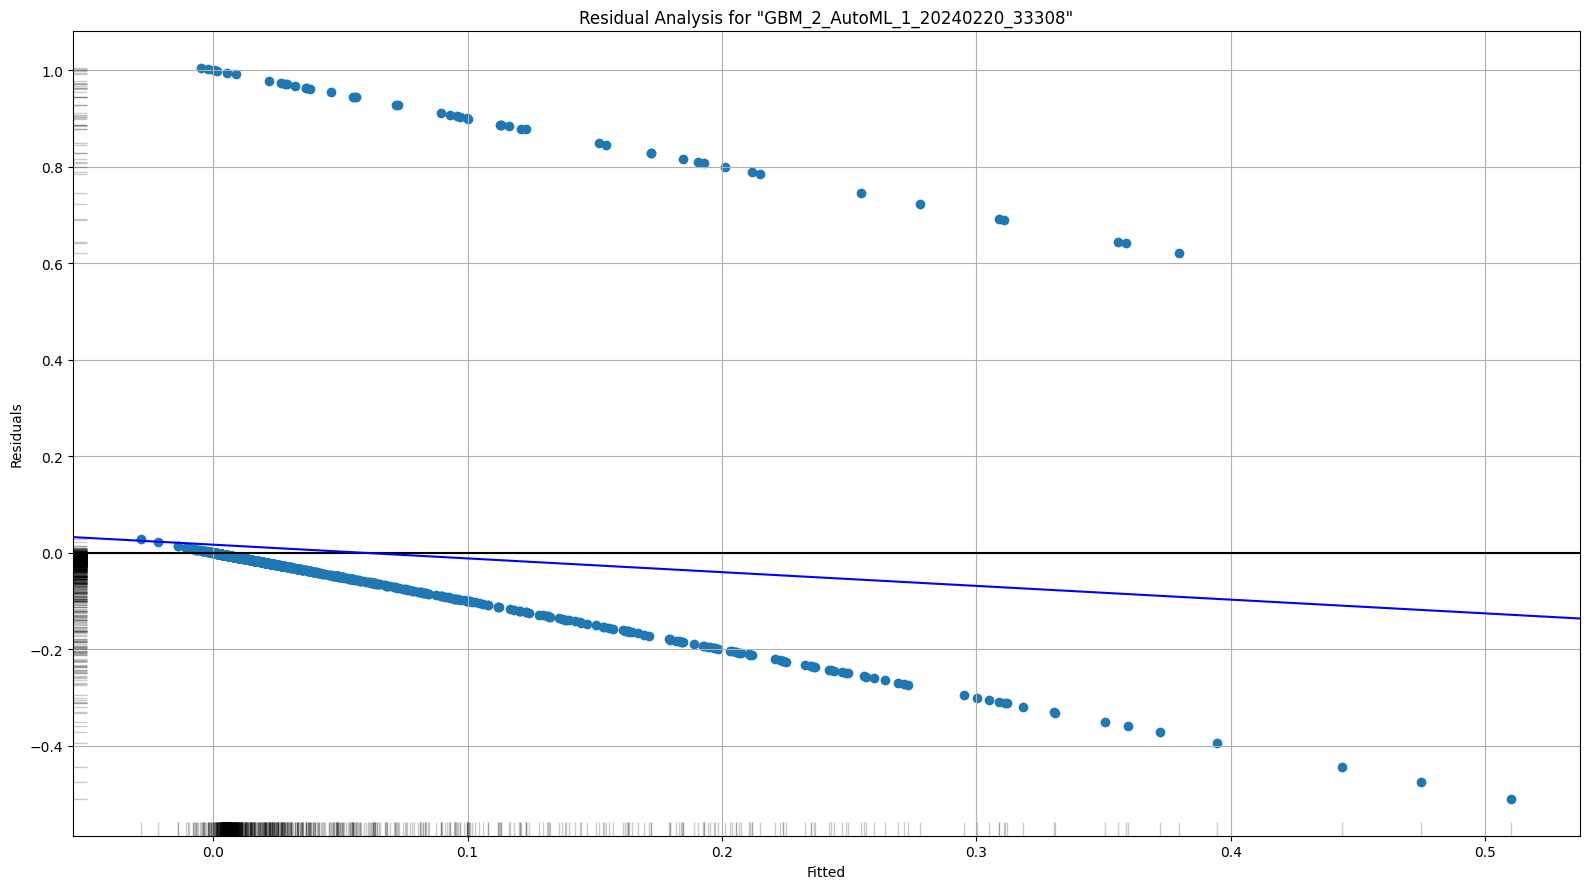

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

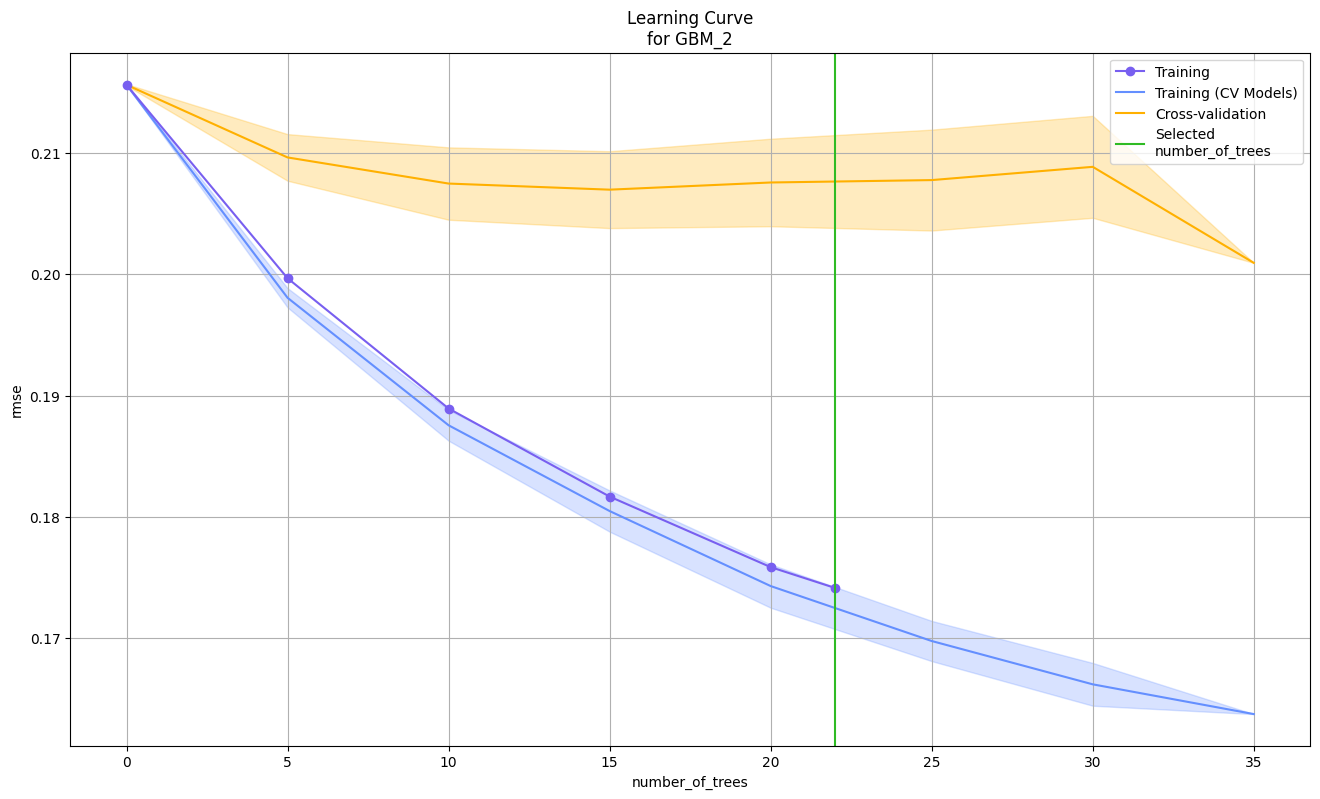

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

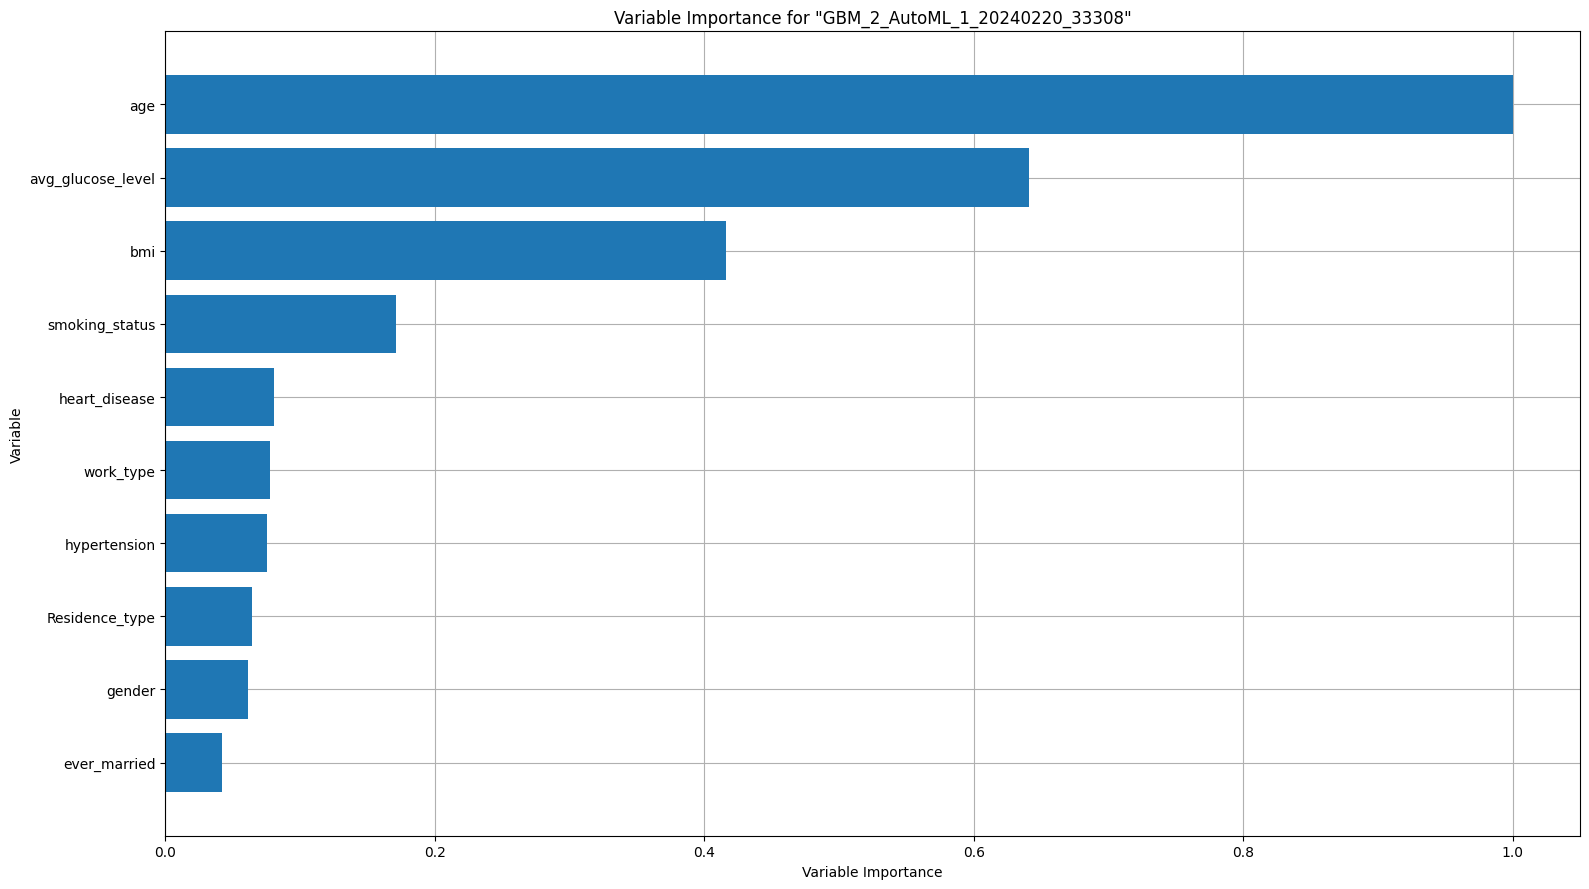

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

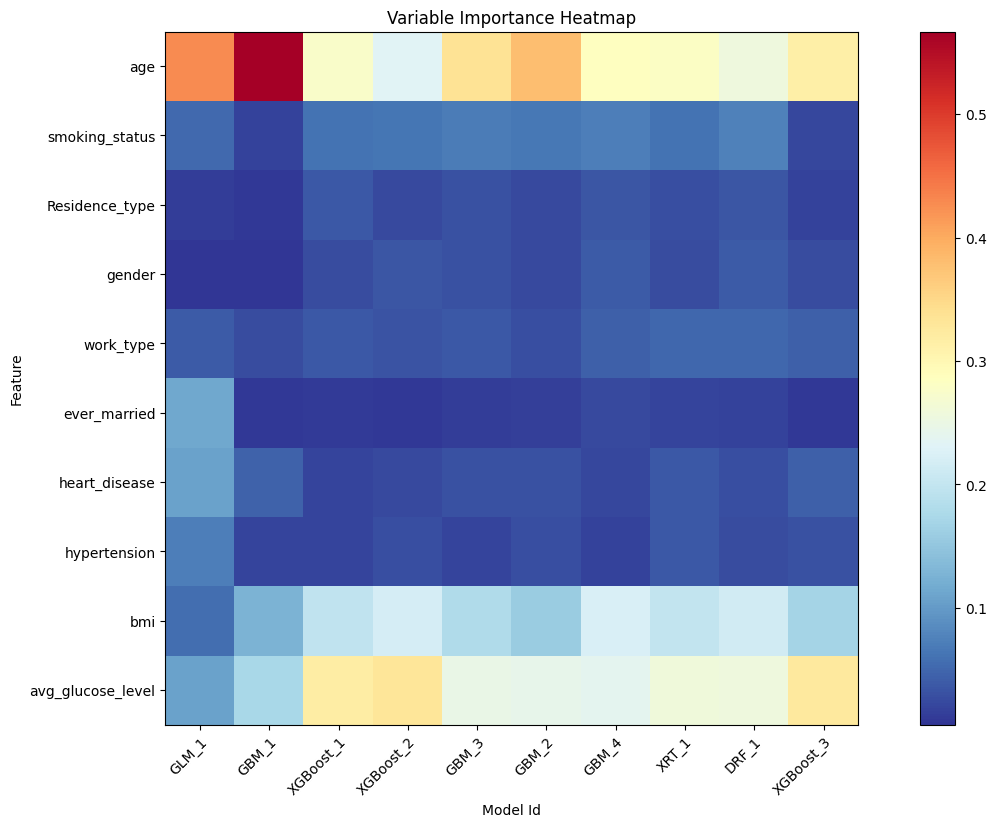

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

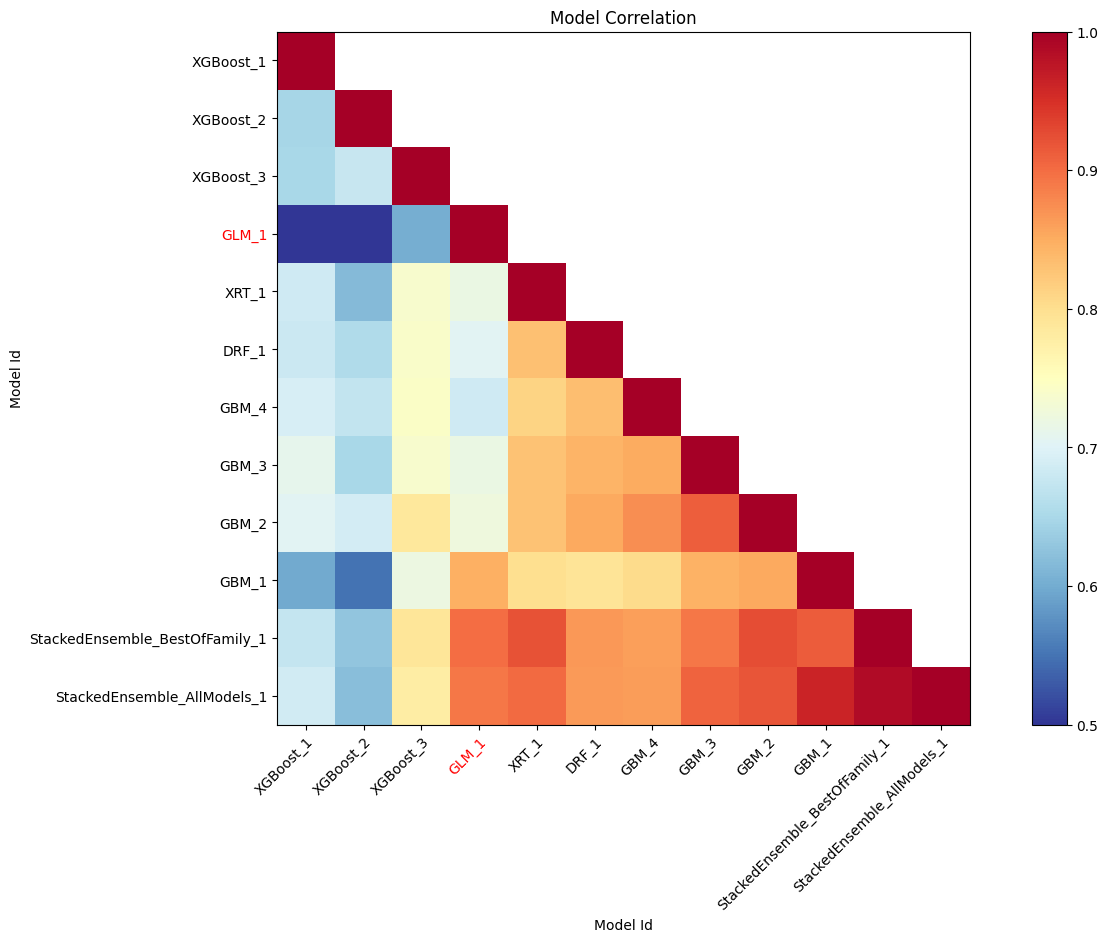

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

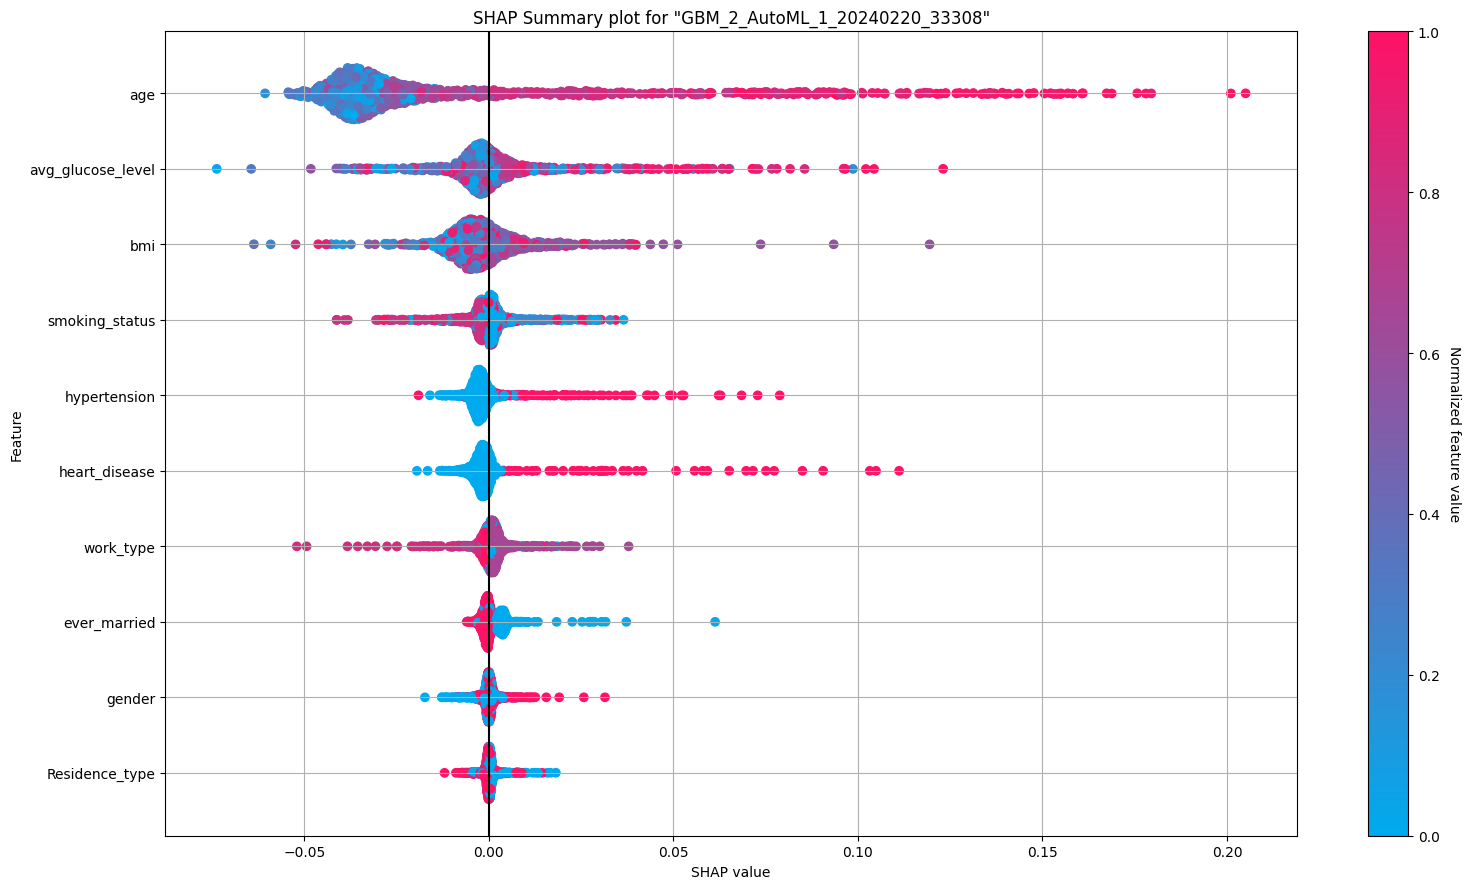

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

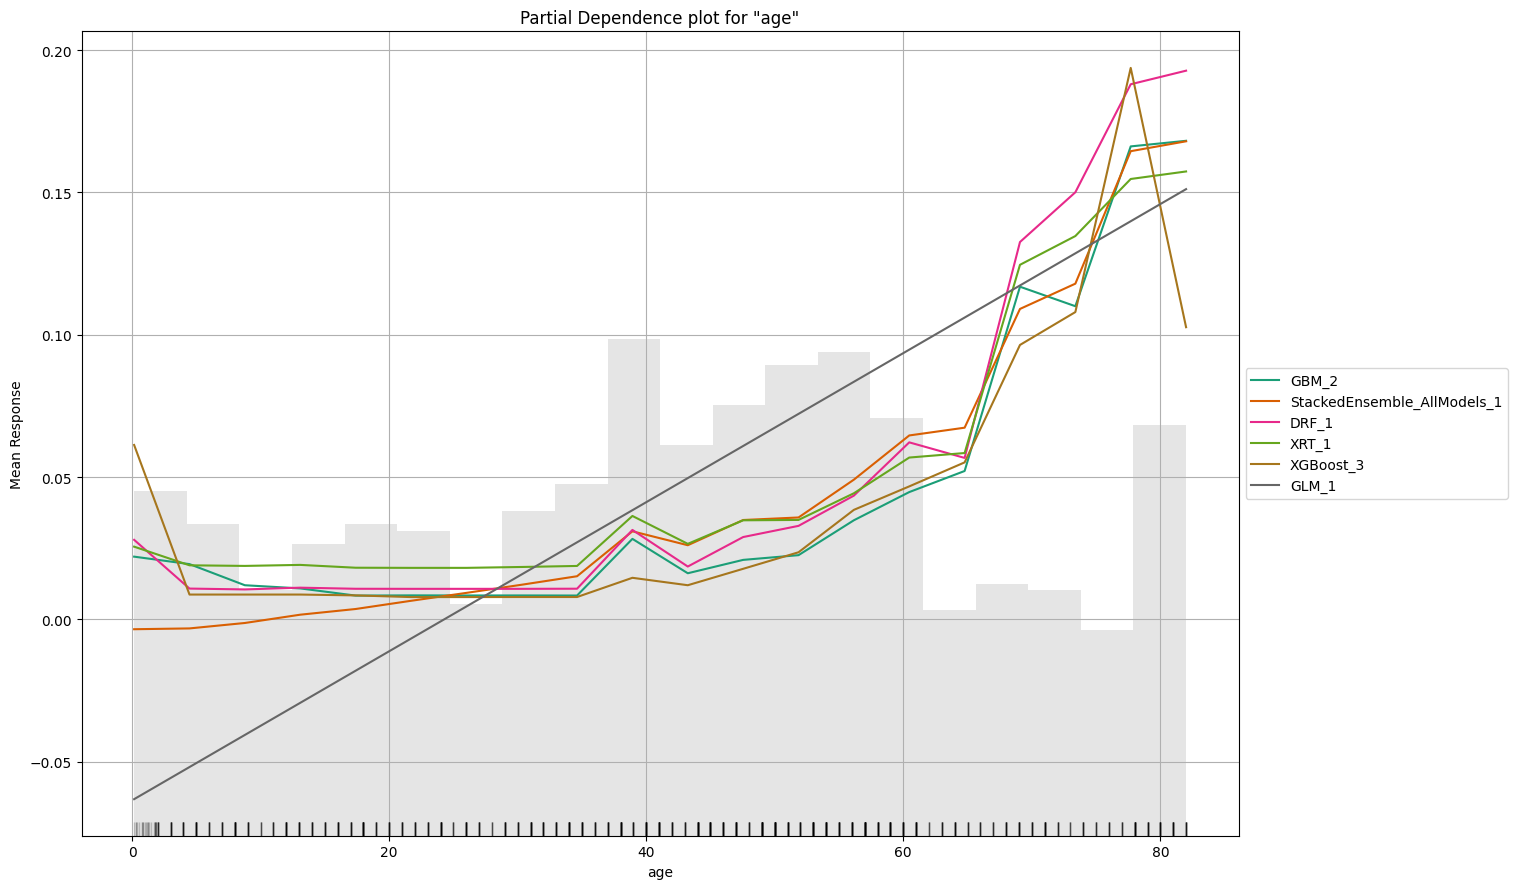

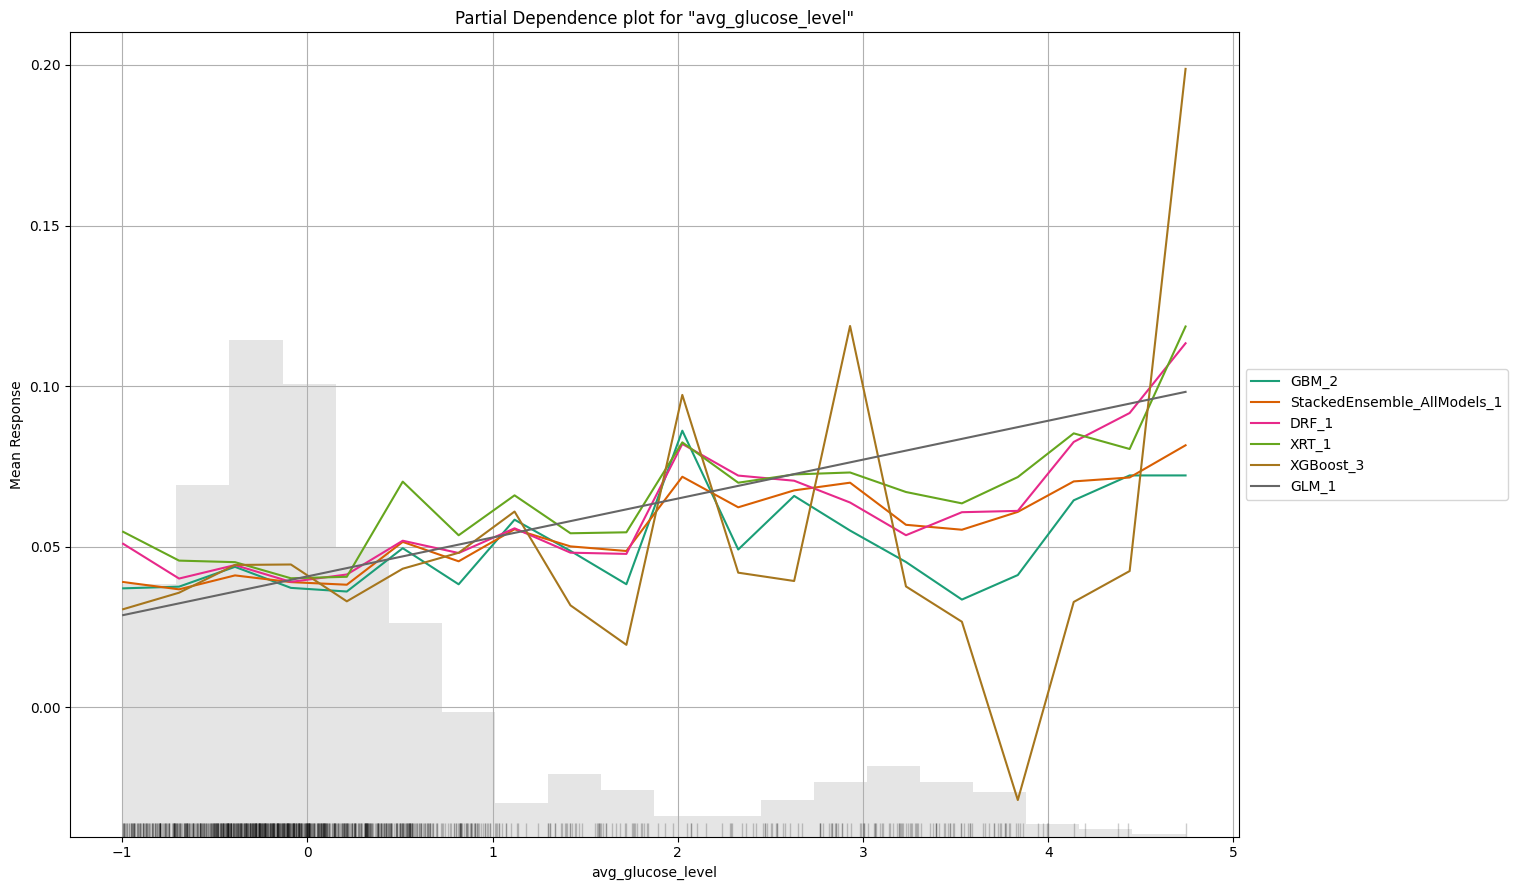

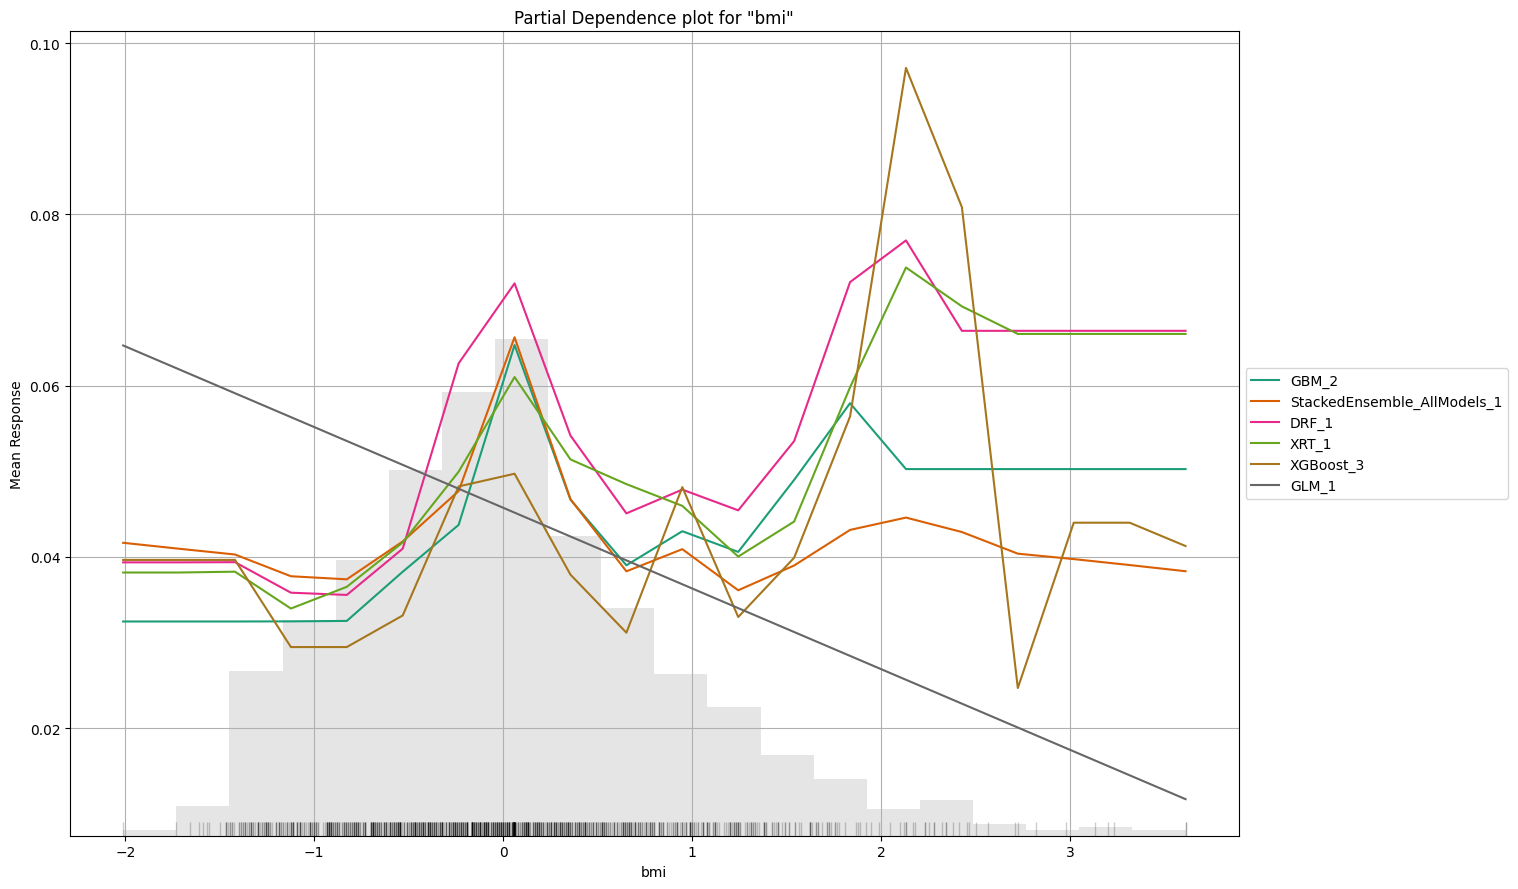

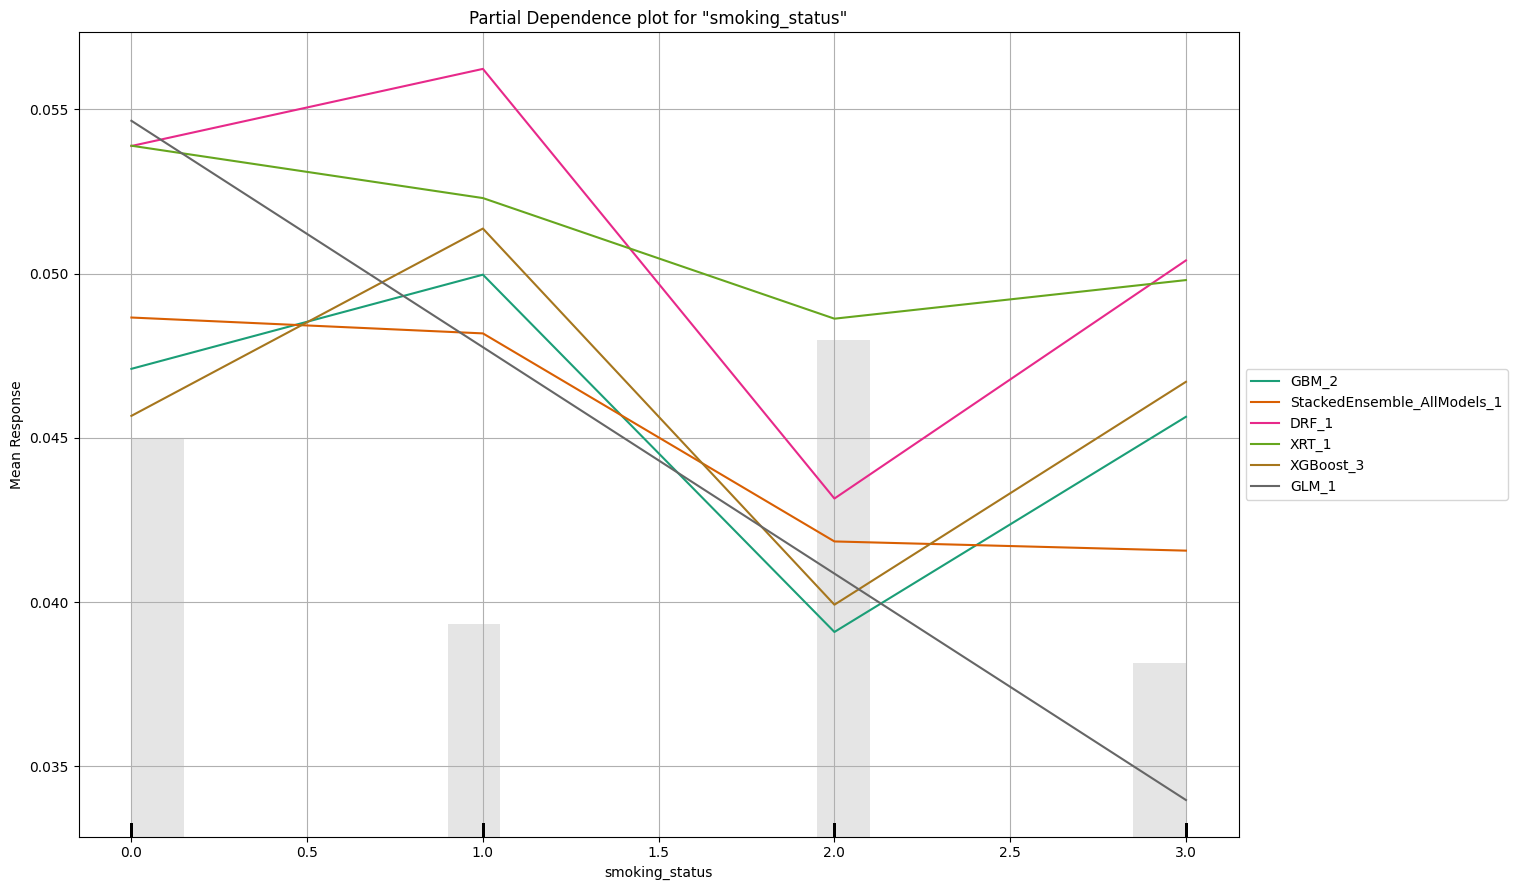

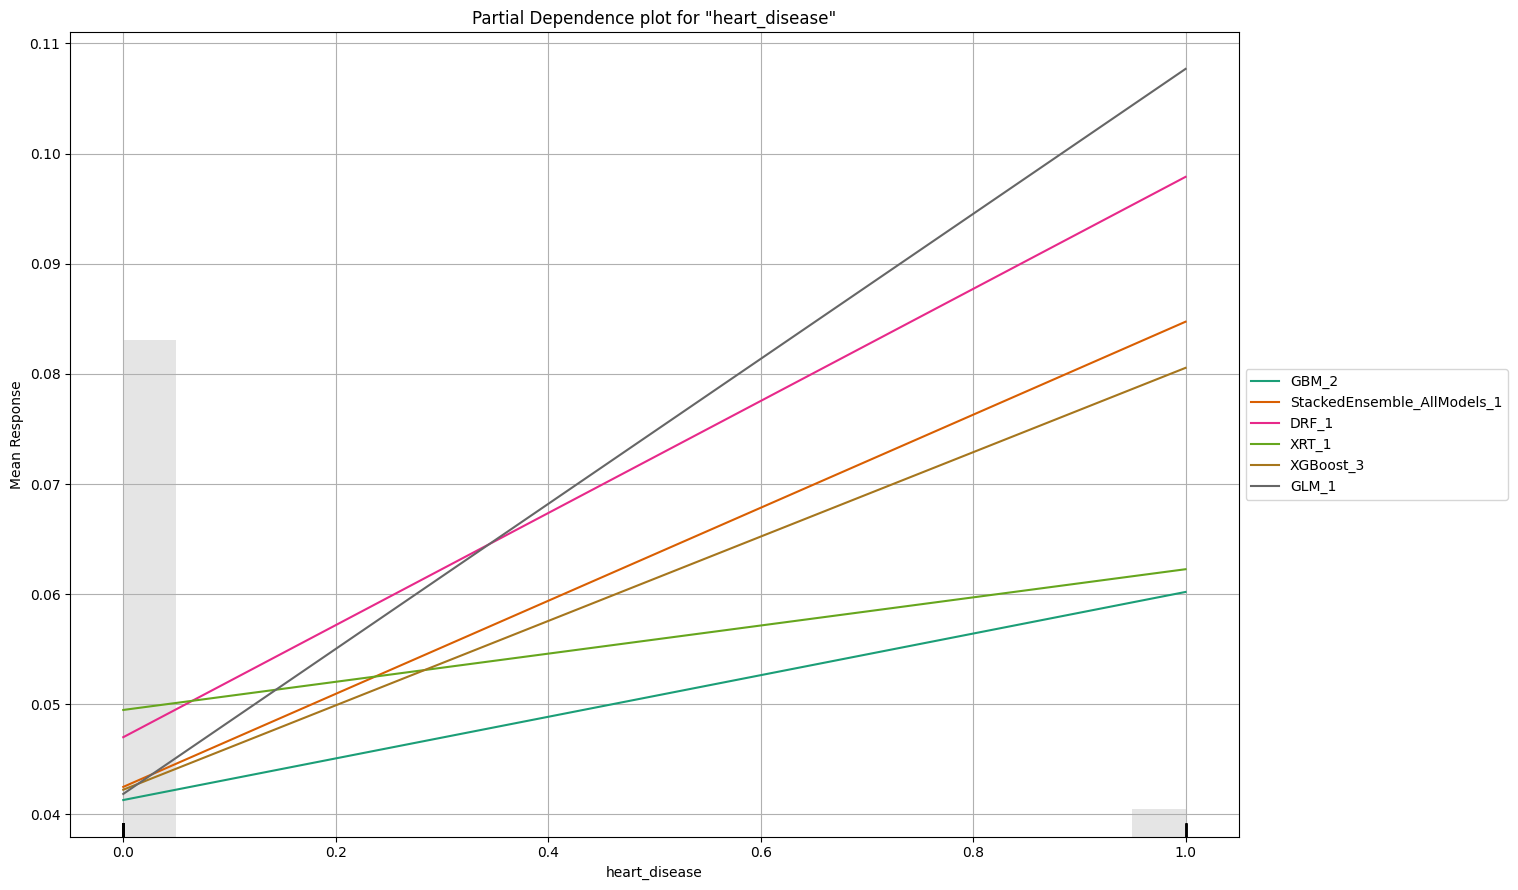

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

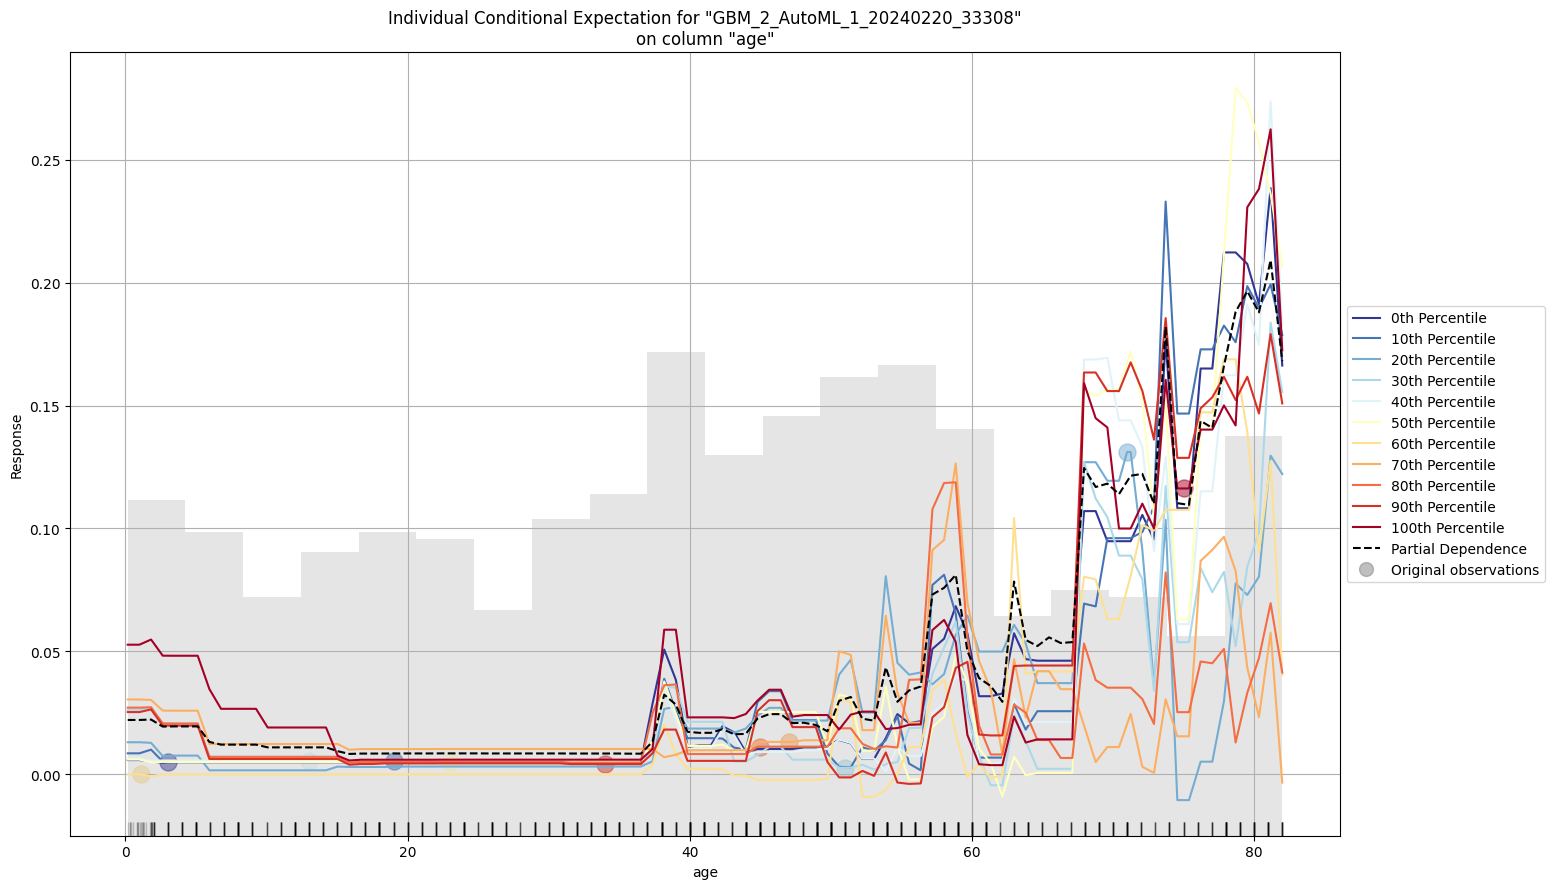

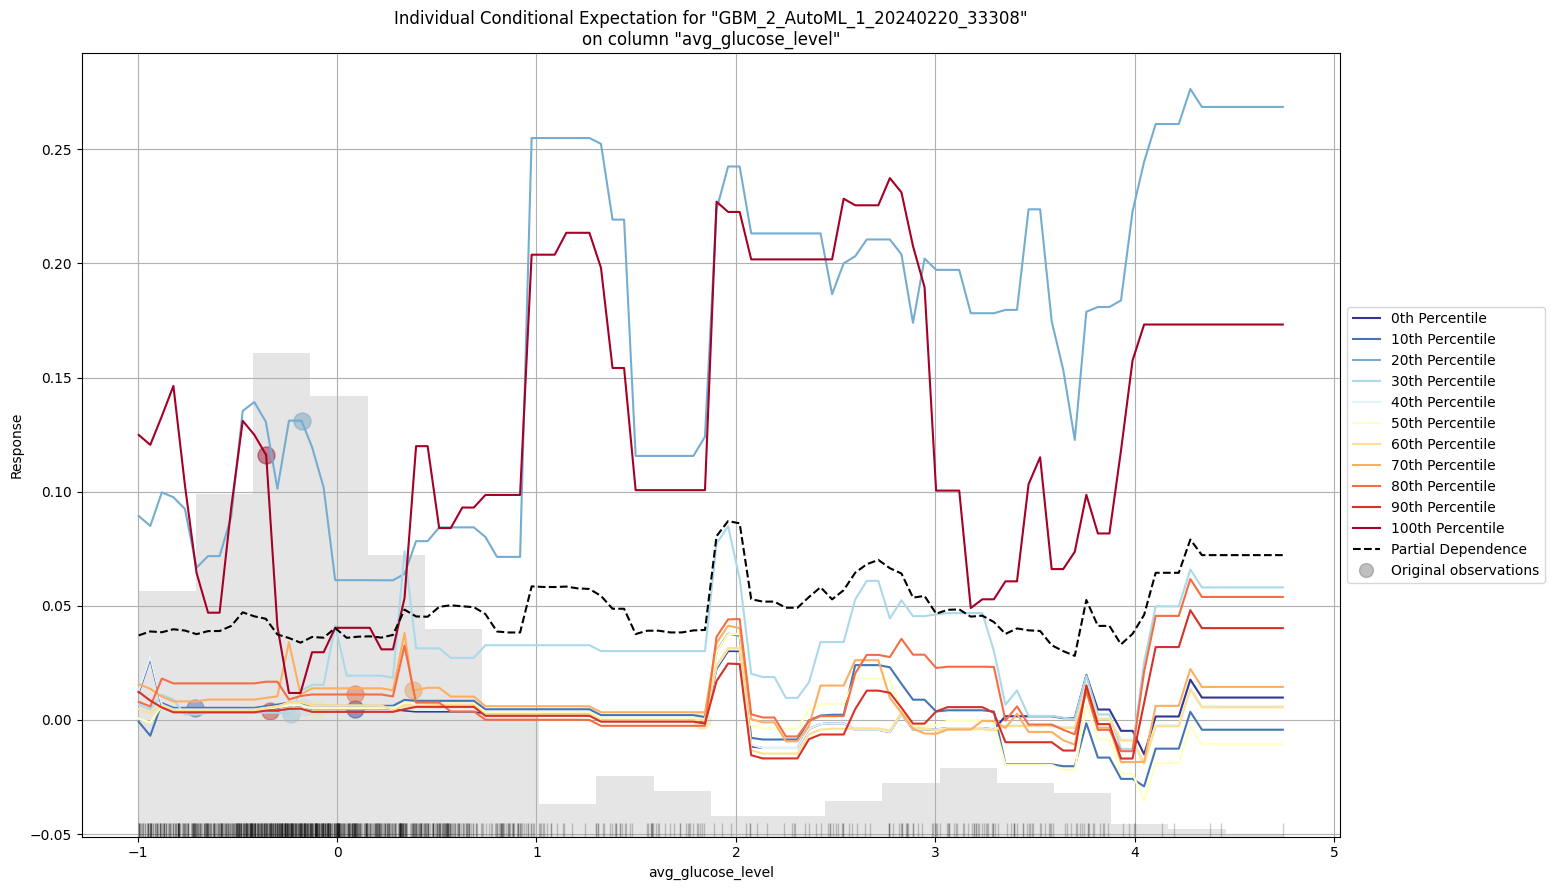

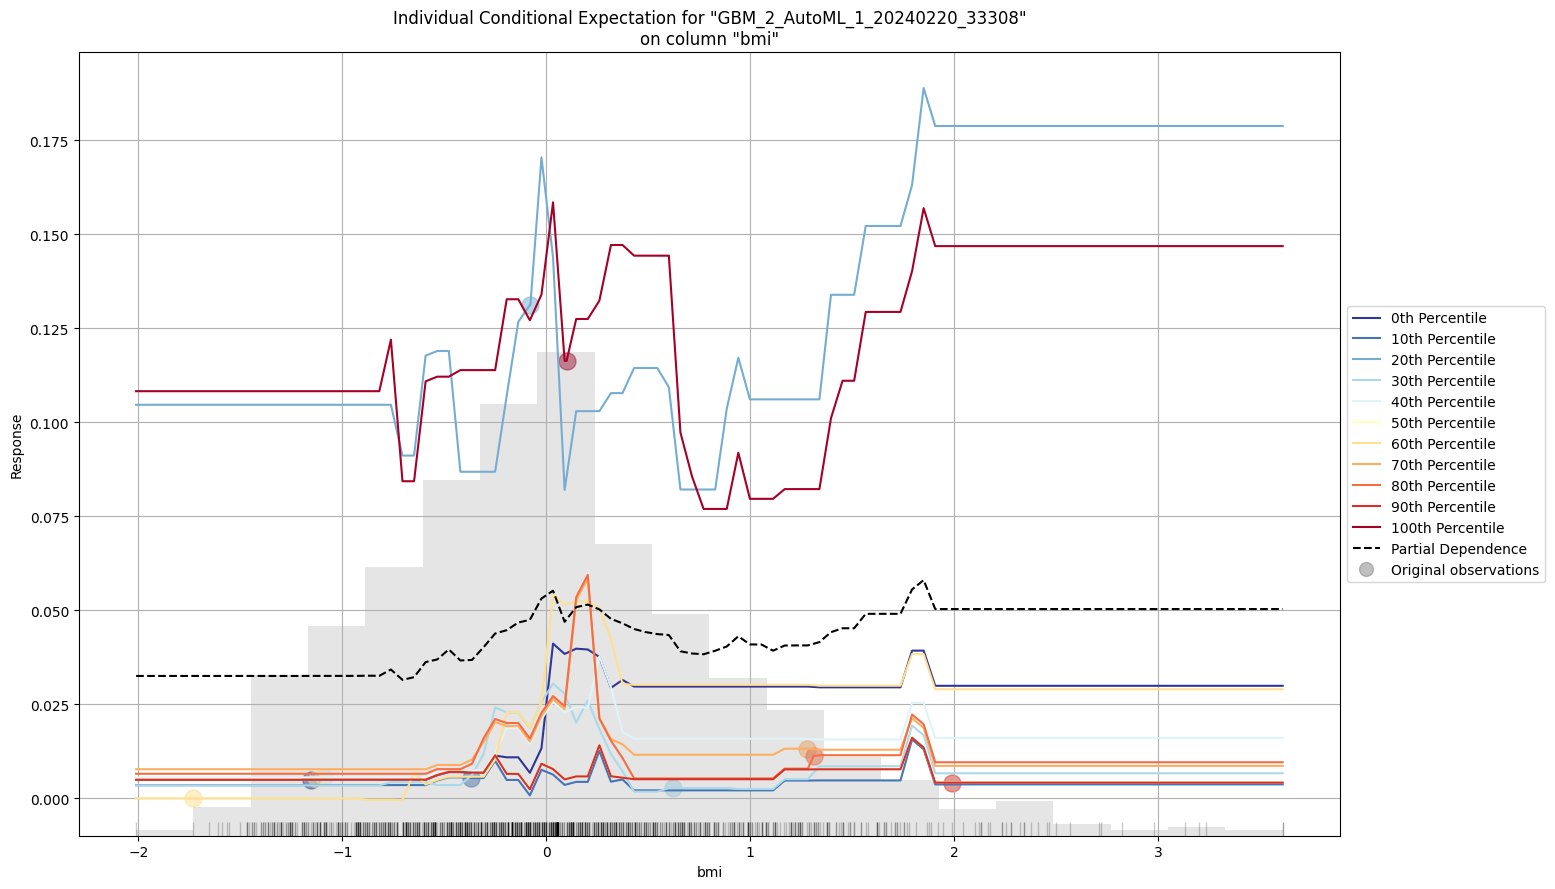

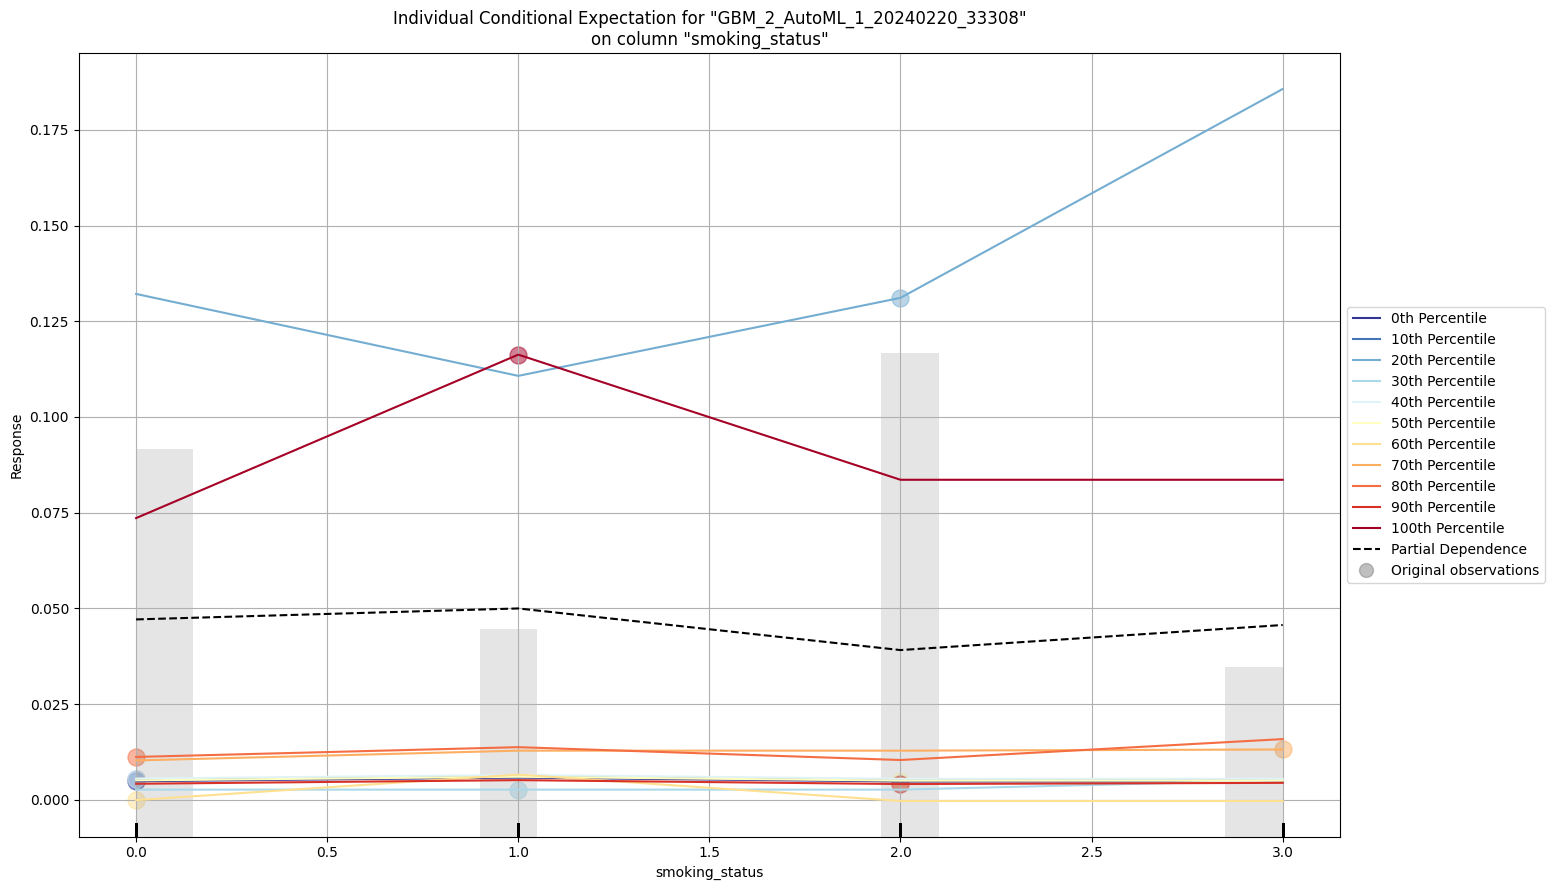

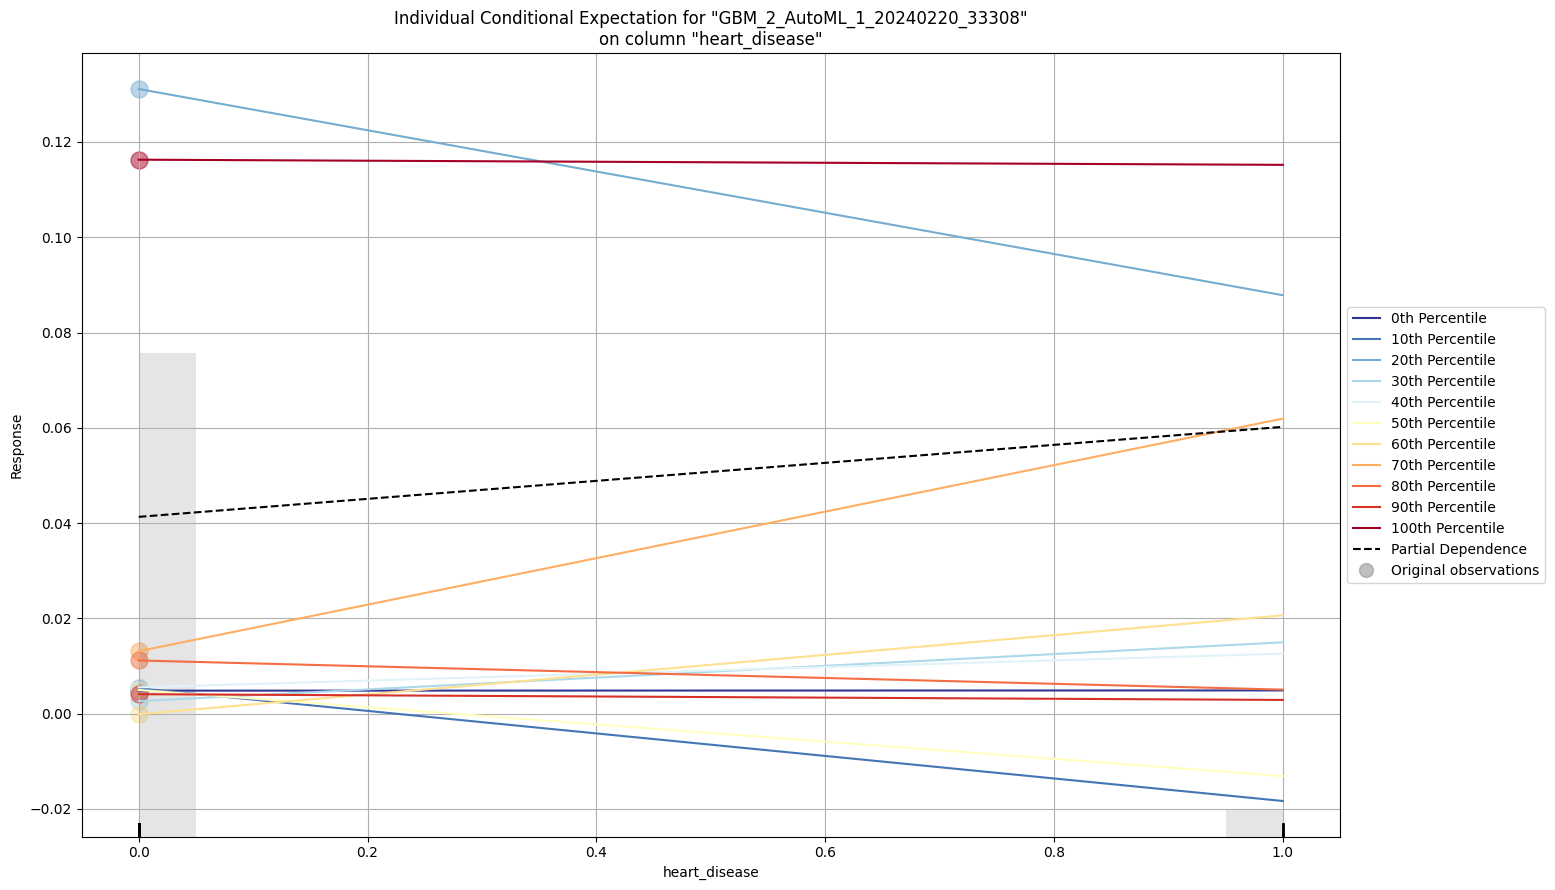

In [95]:
explain_model = aml.explain(frame = df_test)

## Answers to the questions

**Q1] Is the relationship significant?**
- Ans -

a) The significance of the relationship between predictor variables and the target variable in a regression model is generally evaluated using p-values. A common threshold for significance is a p-value of less than 0.05.

b) From OLS Regression Results, we can see that the variables ever_married, age, hypertension, heart_disease, avg_glucose_level, and bmi have p-values less than 0.05, indicating that these relationships are statistically significant.

c) Variables with p-values greater than 0.05 may not have a statistically significant relationship with the target variable stroke.

**Q2]Are any model assumptions violated?**
- Ans -

a) No or little multicollinerity - This can be determined by correlation matrix. For this model some of the assumptions are violated. Multicollinearity exists between variables age and ever_married.

b) No autocorrelation can be determined with Durbin-Watson test -  The Durbin-Watson statistic ranges from 0 to 4, where a value near 2 suggests no autocorrelation. A value less than 2, and particularly as low as 0.152, indicates positive autocorrelation.

**Q3]Is there any multicollinearity in the model?**
- Ans - Yes, there is multicollinearity in the model, according to the heatmap and VIF. Using VIF taking a threshold of 5, it is seen that age, ever_married, avg_glucose_level, and bmi have multicollinearity. From Heatmaps it is seen that age and ever_married are related.

**Q4]In the multivariate models are predictor variables independent of all the other predictor variables?**
- Ans - Multivariate models are statistical models that involve more than one dependent variable or response variable. I have a model that has binary classification. It is a univariate problem. According to heatmap, predictor variables such as age and ever_married are positively related to each other.

**Q5]In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**
- Ans - According to the variable importance, age ranks the most significant variable followed by avg_glucose_level, bmi, smoking_status, and heart_disease. The features with least importance are ever_married, followed by gender and residence_type. Each feature has some or the other imporatance in predicting the target variable. Therefore, insignificant features are not excluded from the model.

**Q6]Does the model make sense?**
- Ans - To be logical, a model has to satisfy all of the assumptions and have a p value and VIF that are within their respective ranges. The RMSE need to be as low as practical, taking into account the target variable's minimum and maximum values. In addition, MSE is 0.04, which is seen to indicate good accuracy. As a result, the model generally makes sense. Depending on their significance, a few more variables might be removed in order to increase accuracy. Additionally, outliers are normalised and preprocessing is also performed to have all the values within the respective ranges.

**Q7]Does regularization help?**
- Ans - After performing 3 different types of regularization(Lasso, Ridge, and Elastic Net), it is seen that regularization has no effect. When we train the dataset without regularization, all the metrics including Accuracy score, is greater for the dataset that is trained without regularization. Values of these are - Without Regularization Accuracy - 90.45, Regularization(lasso) - 90.403,Regularization(Ridge)- 89.89, Regularization(Elastic Net)- 90.184

**Q8]Which independent variables are significant?**
- Ans - According to the variable importance, the independent variables such as age, ranks the most significant variable followed by avg_glucose_level, bmi, smoking_status, and heart_disease. The features with least importance are ever_married, followed by gender and residence_type.

**Q9]Which hyperparameters are important?**
- Ans -

a) H2OAutoML Hyperparameters for Model Training:
- max_runtime_secs: Maximum time (in seconds) that the AutoML process is allowed to run. After this time limit is reached, the AutoML process will stop and return the best model found up to that point.
- sort_metric: The metric used for sorting and selecting the best models. In this case, 'MAE' (Mean Absolute Error) is specified. This is the metric used to evaluate and compare model performance during the AutoML process.
- max_models: The maximum number of models to build during the AutoML process. Once this limit is reached, the process stops.
- seed: Seed for reproducibility. Setting a seed ensures that the random processes involved in model building are the same across different runs, making the results reproducible.
- exclude_algos: A list of algorithms to exclude from the AutoML process. In this case, 'DeepLearning' is excluded, meaning that deep learning models will not be considered during AutoML.

b)H2OGeneralizedLinearEstimator Hyperparameters for Regularization:
- family: Specifies the type of distribution for the response variable. In this case, it is set to 'binomial' since you are dealing with a binary classification problem (0 or 1 outcomes).
- lambda_: The regularization strength, also known as the lambda parameter. It controls the amount of regularization applied to the model. Smaller values of lambda result in stronger regularization, helping prevent overfitting.
- alpha: The elastic net mixing parameter, which controls the balance between L1 (Lasso) and L2 (Ridge) regularization. When alpha is 0, it corresponds to L2 regularization only. When alpha is 1, it corresponds to L1 regularization only. Values between 0 and 1 provide a mix of both.

**Q10]Coding professionalism?**
- Ans - Yes

## REFERENCES

- H2O Documentation: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html?_ga=2.129161676.1179250264.1708398551-1770022984.1708209167
- Scikit-Learn Documentation: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
- Seaborn Documentation: https://seaborn.pydata.org/tutorial/introduction.html
- Analytics Vidhya - https://www.analyticsvidhya.com/blog/2023/01/the-future-of-machine-learning-automl/
- OLS Model- http://net-informations.com/ds/mla/ols.html
- StatsModel - https://www.statsmodels.org/stable/index.html

## LICENSE

MIT License

Copyright (c) 2024 pranitee23

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.